# **INVESTIGACION PARA TESIS DE GRADO**

**ESTUDIANTES: Vladimir Alvarez Lhabriel y Andrés Ortega Ramos**

**TEMA**:

**USO DE INTELIGENCIA ARTIFICIAL PARA DETECCION, PREDICCION Y/O TRATAMIENTO
DEL PARKINSON**

**SET DE DATOS DE OXFORD**

**EJECUCION PURA DE TODOS LOS MODELOS SIN SMOTE**

In [1]:
# ============================================================================
# COMPARATIVA DE 8 MODELOS DE MACHINE LEARNING PARA DETECCIÓN DE PARKINSON
# Dataset: Oxford Parkinson (n=195) - Validación Cruzada 10-Fold
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve,
    classification_report
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

In [3]:
# ===============================
# 1. CARGA Y PREPROCESAMIENTO
# ===============================
print("="*80)
print("📥 CARGA Y ANÁLISIS DEL DATASET DE OXFORD PARKINSON")
print("="*80)

# Cargar datos
url = "https://raw.githubusercontent.com/VladoAlvarez/tesis/refs/heads/main/Oxford_parkinsons_data.csv"
df = pd.read_csv(url, sep=';')

📥 CARGA Y ANÁLISIS DEL DATASET DE OXFORD PARKINSON


In [4]:
# Preparar datos
X = df.drop(['status', 'name'], axis=1)
y = df['status']
feature_names = X.columns.tolist()

print(f"\n📊 DATOS DEL DATASET:")
print(f"   • Muestras totales: {X.shape[0]}")
print(f"   • Características: {X.shape[1]}")
print(f"   • Parkinson (1): {sum(y==1)} muestras ({sum(y==1)/len(y)*100:.1f}%)者に {len(y)*100:.1f}%")
print(f"   • Control (0): {sum(y==0)} muestras ({sum(y==0)/len(y)*100:.1f}%) de {len(y)*100:.1f}%")

print(f"\n📋 MUESTRA DE CARACTERÍSTICAS:")
print(X.iloc[:3, :5].to_string())


📊 DATOS DEL DATASET:
   • Muestras totales: 195
   • Características: 22
   • Parkinson (1): 147 muestras (75.4%)者に 19500.0%
   • Control (0): 48 muestras (24.6%) de 19500.0%

📋 MUESTRA DE CARACTERÍSTICAS:
   MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)
0     11999200      15730200       7499700             784                 7
1     12240000      14865000      11381900             968                 8
2     11668200      13111100      11155500            1050                 9


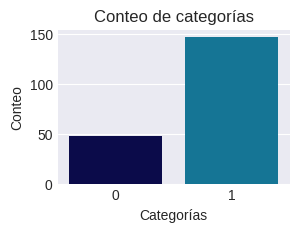

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(3, 2))

# Crear una paleta específica
palette_colors = sns.color_palette('ocean', n_colors=len(df['status'].unique()))

sns.countplot(data=df, x='status', hue='status',
              palette=palette_colors, legend=False)

# Añadir etiquetas y título
plt.xlabel('Categorías')
plt.ylabel('Conteo')
plt.title('Conteo de categorías')

plt.show()

In [6]:
# Escalado de características (IMPORTANTE para SVM, KNN, Red Neuronal)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names)

In [7]:
# ===============================
# 2. CONFIGURACIÓN DE VALIDACIÓN CRUZADA
# ===============================
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
print(f"\n✅ Configuración: Validación Cruzada {n_splits}-Fold Estratificada")


✅ Configuración: Validación Cruzada 10-Fold Estratificada


In [8]:
# ===============================
# 3. DEFINICIÓN DE TODOS LOS MODELOS
# ===============================
print("\n" + "="*80)
print("🤖 CONFIGURACIÓN DE LOS 8 MODELOS DE MACHINE LEARNING")
print("="*80)

models = {
    # 1. REGRESIÓN LOGÍSTICA
    'Regresión Logística': LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced'  # Para manejar desbalance
    ),

    # 2. ÁRBOLES DE DECISIÓN
    'Árbol de Decisión': DecisionTreeClassifier(
        max_depth=5,  # Limitado para evitar overfitting
        random_state=42,
        class_weight='balanced'
    ),

    # 3. RANDOM FOREST
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=8,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),

    # 4. GRADIENT BOOSTING
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ),

    # 5. XGBOOST
    'XGBoost': XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    ),

    # 6. K-NEAREST NEIGHBORS
    'KNN': KNeighborsClassifier(
        n_neighbors=5,  # Valor típico, podría optimizarse
        weights='distance',
        metric='euclidean'
    ),

    # 7. SUPPORT VECTOR MACHINE
    'SVM': SVC(
        kernel='rbf',
        C=1.0,
        probability=True,  # Para obtener probabilidades
        random_state=42,
        class_weight='balanced'
    )
}

print("\n📝 PARÁMETROS DE MODELOS:")
for name, model in models.items():
    print(f"   • {name}: {model.__class__.__name__}")


🤖 CONFIGURACIÓN DE LOS 8 MODELOS DE MACHINE LEARNING

📝 PARÁMETROS DE MODELOS:
   • Regresión Logística: LogisticRegression
   • Árbol de Decisión: DecisionTreeClassifier
   • Random Forest: RandomForestClassifier
   • Gradient Boosting: GradientBoostingClassifier
   • XGBoost: XGBClassifier
   • KNN: KNeighborsClassifier
   • SVM: SVC


In [9]:
# ===============================
# 4. FUNCIÓN PARA RED NEURONAL
# ===============================
def create_parkinson_nn(input_dim, use_regularization=True):
    """Crea una red neuronal para clasificación binaria"""

    model = keras.Sequential()

    # Capa de entrada
    model.add(layers.Input(shape=(input_dim,)))

    # Primera capa oculta
    if use_regularization:
        model.add(layers.Dense(64, activation='relu',
                              kernel_regularizer=regularizers.l2(0.01)))
    else:
        model.add(layers.Dense(64, activation='relu'))

    model.add(layers.Dropout(0.3))
    model.add(layers.BatchNormalization())

    # Segunda capa oculta
    if use_regularization:
        model.add(layers.Dense(32, activation='relu',
                              kernel_regularizer=regularizers.l2(0.01)))
    else:
        model.add(layers.Dense(32, activation='relu'))

    model.add(layers.Dropout(0.3))

    # Capa de salida
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compilación
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy',
                keras.metrics.AUC(name='auc'),
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall')]
    )

    return model

In [10]:
# ===============================
# 5. EVALUACIÓN DE MODELOS TRADICIONALES (1-7)
# ===============================
print("\n" + "="*80)
print("🔬 EVALUANDO MODELOS 1-7 CON VALIDACIÓN CRUZADA")
print("="*80)

results = {}
all_predictions = {}
all_probabilities = {}

for model_name, model in models.items():
    print(f"\n📊 Evaluando: {model_name}...")

    # Métricas a almacenar
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'auc': []
    }

    # Para almacenar todas las predicciones
    y_all_pred = []
    y_all_true = []
    y_all_proba = []

    # Validación cruzada manual para obtener predicciones
    for fold, (train_idx, test_idx) in enumerate(cv.split(X_scaled, y), 1):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Entrenar modelo
        model.fit(X_train, y_train)

        # Predecir
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred

        # Almacenar predicciones
        y_all_pred.extend(y_pred)
        y_all_true.extend(y_test)
        y_all_proba.extend(y_proba)

        # Calcular métricas para este fold
        metrics['accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['precision'].append(precision_score(y_test, y_pred))
        metrics['recall'].append(recall_score(y_test, y_pred))
        metrics['f1'].append(f1_score(y_test, y_pred))
        metrics['auc'].append(roc_auc_score(y_test, y_proba))

    # Calcular promedios y desviaciones
    results[model_name] = {
        'accuracy_mean': np.mean(metrics['accuracy']),
        'accuracy_std': np.std(metrics['accuracy']),
        'precision_mean': np.mean(metrics['precision']),
        'precision_std': np.std(metrics['precision']),
        'recall_mean': np.mean(metrics['recall']),
        'recall_std': np.std(metrics['recall']),
        'f1_mean': np.mean(metrics['f1']),
        'f1_std': np.std(metrics['f1']),
        'auc_mean': np.mean(metrics['auc']),
        'auc_std': np.std(metrics['auc']),
        'model': model
    }

    # Almacenar predicciones completas
    all_predictions[model_name] = y_all_pred
    all_probabilities[model_name] = y_all_proba

    print(f"   ✅ AUC: {results[model_name]['auc_mean']:.3f} (±{results[model_name]['auc_std']:.3f})")
    print(f"   📈 F1-Score: {results[model_name]['f1_mean']:.3f}")


🔬 EVALUANDO MODELOS 1-7 CON VALIDACIÓN CRUZADA

📊 Evaluando: Regresión Logística...
   ✅ AUC: 0.912 (±0.057)
   📈 F1-Score: 0.845

📊 Evaluando: Árbol de Decisión...
   ✅ AUC: 0.851 (±0.088)
   📈 F1-Score: 0.924

📊 Evaluando: Random Forest...
   ✅ AUC: 0.966 (±0.038)
   📈 F1-Score: 0.947

📊 Evaluando: Gradient Boosting...
   ✅ AUC: 0.958 (±0.043)
   📈 F1-Score: 0.952

📊 Evaluando: XGBoost...
   ✅ AUC: 0.972 (±0.037)
   📈 F1-Score: 0.950

📊 Evaluando: KNN...
   ✅ AUC: 0.979 (±0.029)
   📈 F1-Score: 0.948

📊 Evaluando: SVM...
   ✅ AUC: 0.943 (±0.039)
   📈 F1-Score: 0.887


In [11]:
# ===============================
# 6. EVALUACIÓN DE RED NEURONAL (MODELO 8)
# ===============================
print("\n" + "="*80)
print("🧠 EVALUANDO MODELO 8: RED NEURONAL ARTIFICIAL")
print("="*80)

# Métricas para red neuronal
nn_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc': [],
    'histories': [],
    'epochs_needed': []
}

y_nn_all_pred = []
y_nn_all_true = []
y_nn_all_proba = []

print("Entrenando red neuronal con validación cruzada...")
for fold, (train_idx, test_idx) in enumerate(cv.split(X_scaled, y), 1):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Crear y entrenar modelo
    nn_model = create_parkinson_nn(X.shape[1], use_regularization=True)

    # Callbacks para optimizar entrenamiento
    early_stopping = callbacks.EarlyStopping(
        monitor='val_auc',
        patience=25,
        restore_best_weights=True,
        mode='max',
        verbose=0
    )

    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=0.00001,
        verbose=0
    )

    # Entrenamiento
    history = nn_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=200,
        batch_size=16,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    nn_metrics['histories'].append(history)
    nn_metrics['epochs_needed'].append(len(history.history['loss']))

    # Evaluación
    y_pred_proba = nn_model.predict(X_test, verbose=0).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Almacenar
    y_nn_all_pred.extend(y_pred)
    y_nn_all_true.extend(y_test)
    y_nn_all_proba.extend(y_pred_proba)

    # Calcular métricas
    nn_metrics['accuracy'].append(accuracy_score(y_test, y_pred))
    nn_metrics['precision'].append(precision_score(y_test, y_pred))
    nn_metrics['recall'].append(recall_score(y_test, y_pred))
    nn_metrics['f1'].append(f1_score(y_test, y_pred))
    nn_metrics['auc'].append(roc_auc_score(y_test, y_pred_proba))

    if fold % 2 == 0:
        print(f"   Fold {fold}/10 - AUC: {nn_metrics['auc'][-1]:.3f}")

# Calcular estadísticas para red neuronal
results['Red Neuronal'] = {
    'accuracy_mean': np.mean(nn_metrics['accuracy']),
    'accuracy_std': np.std(nn_metrics['accuracy']),
    'precision_mean': np.mean(nn_metrics['precision']),
    'precision_std': np.std(nn_metrics['precision']),
    'recall_mean': np.mean(nn_metrics['recall']),
    'recall_std': np.std(nn_metrics['recall']),
    'f1_mean': np.mean(nn_metrics['f1']),
    'f1_std': np.std(nn_metrics['f1']),
    'auc_mean': np.mean(nn_metrics['auc']),
    'auc_std': np.std(nn_metrics['auc']),
    'epochs_mean': np.mean(nn_metrics['epochs_needed']),
    'type': 'neural_network'
}

all_predictions['Red Neuronal'] = y_nn_all_pred
all_probabilities['Red Neuronal'] = y_nn_all_proba

print(f"\n✅ Red Neuronal - Resultados finales:")
print(f"   • AUC: {results['Red Neuronal']['auc_mean']:.3f} (±{results['Red Neuronal']['auc_std']:.3f})")
print(f"   • F1-Score: {results['Red Neuronal']['f1_mean']:.3f}")
print(f"   • Épocas promedio necesarias: {results['Red Neuronal']['epochs_mean']:.0f}")


🧠 EVALUANDO MODELO 8: RED NEURONAL ARTIFICIAL
Entrenando red neuronal con validación cruzada...
   Fold 2/10 - AUC: 1.000
   Fold 4/10 - AUC: 0.933


   Fold 6/10 - AUC: 0.983
   Fold 8/10 - AUC: 1.000
   Fold 10/10 - AUC: 1.000

✅ Red Neuronal - Resultados finales:
   • AUC: 0.981 (±0.024)
   • F1-Score: 0.949
   • Épocas promedio necesarias: 56



📈 GENERANDO VISUALIZACIONES COMPARATIVAS


(0.7, 1.05)

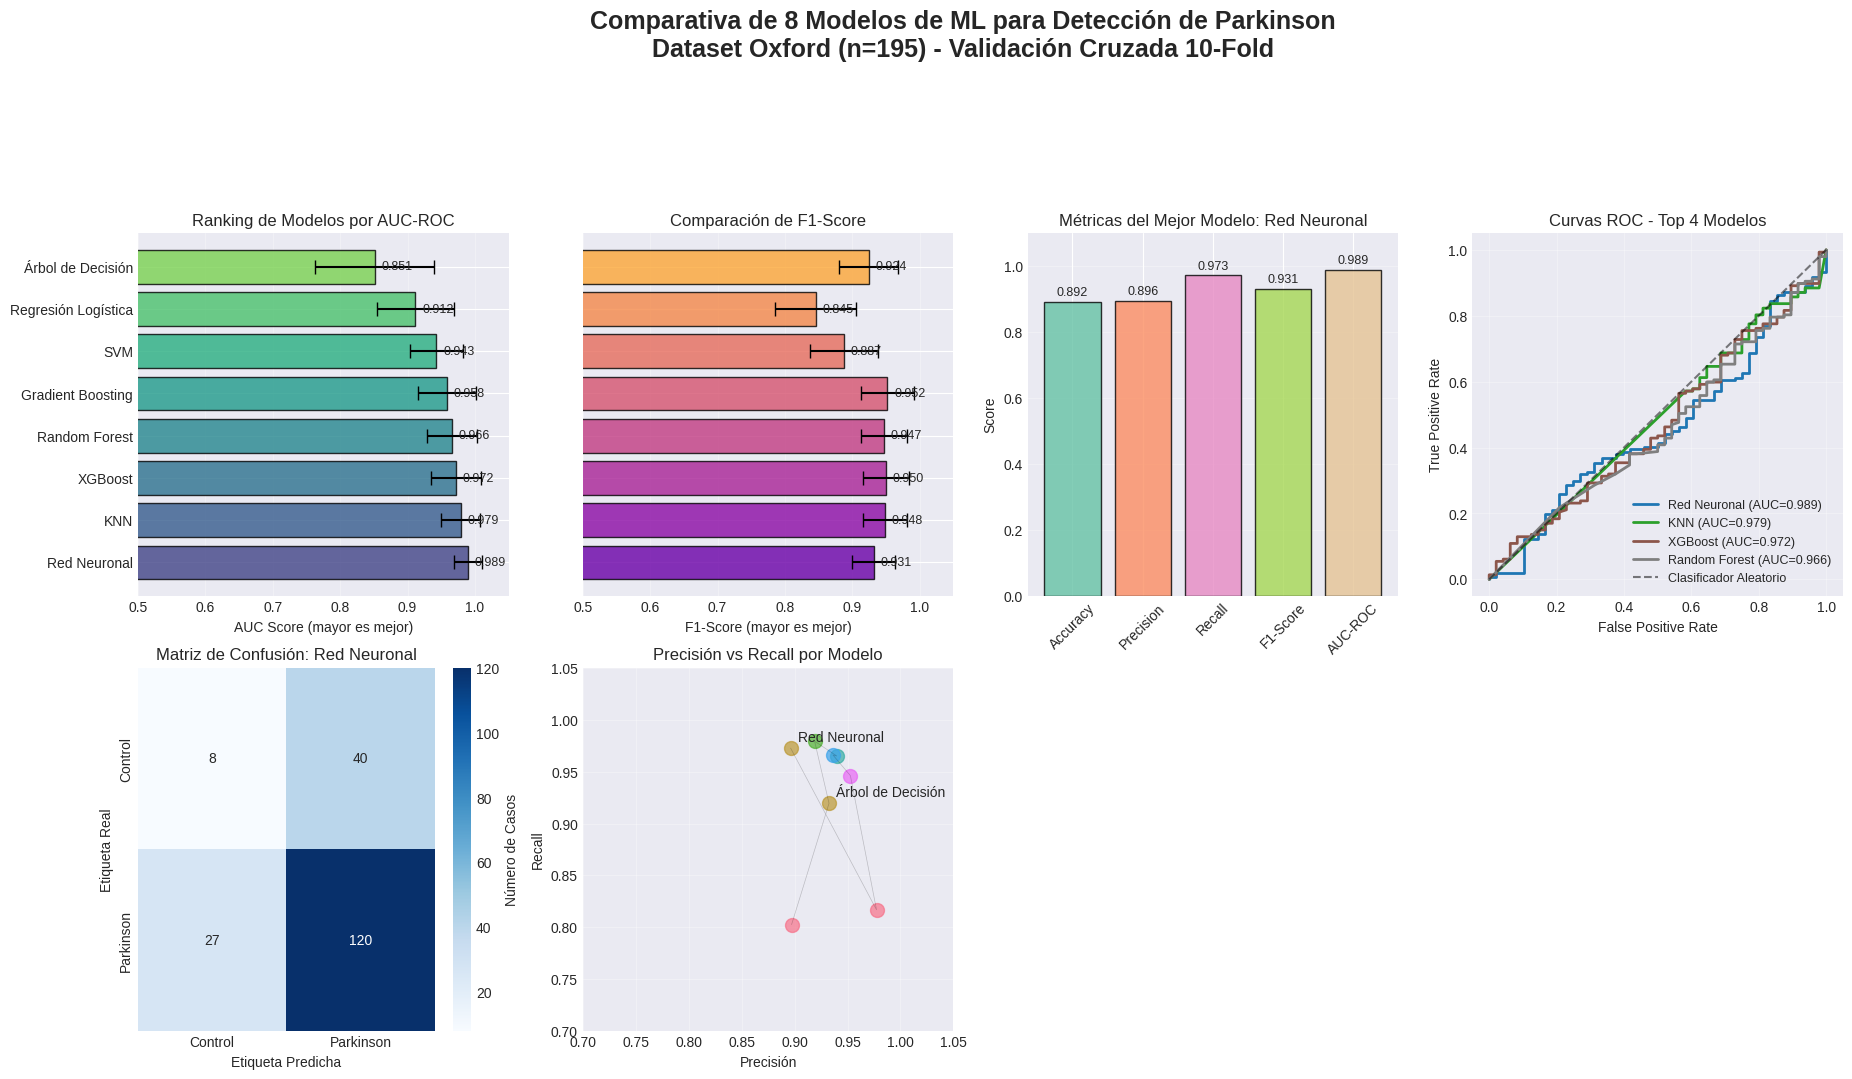

In [12]:
# ===============================
# 7. VISUALIZACIÓN COMPARATIVA
# ===============================
print("\n" + "="*80)
print("📈 GENERANDO VISUALIZACIONES COMPARATIVAS")
print("="*80)

# Crear figura con múltiples subplots
fig = plt.figure(figsize=(22, 16))
fig.suptitle('Comparativa de 8 Modelos de ML para Detección de Parkinson\nDataset Oxford (n=195) - Validación Cruzada 10-Fold',
             fontsize=18, fontweight='bold', y=1.02)

# ===== SUBPLOT 1: Comparación de AUC de todos los modelos =====
ax1 = plt.subplot(3, 4, 1)
model_names = list(results.keys())
auc_means = [results[m]['auc_mean'] for m in model_names]
auc_stds = [results[m]['auc_std'] for m in model_names]

# Ordenar por AUC descendente
sorted_indices = np.argsort(auc_means)[::-1]
sorted_models = [model_names[i] for i in sorted_indices]
sorted_auc = [auc_means[i] for i in sorted_indices]
sorted_stds = [auc_stds[i] for i in sorted_indices]

bars = ax1.barh(range(len(sorted_models)), sorted_auc,
                xerr=sorted_stds, capsize=5,
                color=plt.cm.viridis(np.linspace(0.2, 0.8, len(sorted_models))),
                edgecolor='black', alpha=0.8)

# Añadir valores en barras
for i, (bar, auc_val) in enumerate(zip(bars, sorted_auc)):
    width = bar.get_width()
    ax1.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{auc_val:.3f}', ha='left', va='center', fontsize=9)

ax1.set_yticks(range(len(sorted_models)))
ax1.set_yticklabels(sorted_models)
ax1.set_xlabel('AUC Score (mayor es mejor)')
ax1.set_title('Ranking de Modelos por AUC-ROC')
ax1.set_xlim([0.5, 1.05])
ax1.grid(axis='x', alpha=0.3)

# ===== SUBPLOT 2: Comparación de F1-Score =====
ax2 = plt.subplot(3, 4, 2)
f1_means = [results[m]['f1_mean'] for m in model_names]
f1_stds = [results[m]['f1_std'] for m in model_names]

sorted_f1 = [f1_means[i] for i in sorted_indices]
sorted_f1_stds = [f1_stds[i] for i in sorted_indices]

bars = ax2.barh(range(len(sorted_models)), sorted_f1,
                xerr=sorted_f1_stds, capsize=5,
                color=plt.cm.plasma(np.linspace(0.2, 0.8, len(sorted_models))),
                edgecolor='black', alpha=0.8)

for i, (bar, f1_val) in enumerate(zip(bars, sorted_f1)):
    width = bar.get_width()
    ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{f1_val:.3f}', ha='left', va='center', fontsize=9)

ax2.set_yticks(range(len(sorted_models)))
ax2.set_yticklabels([])  # Ocultar etiquetas para no duplicar
ax2.set_xlabel('F1-Score (mayor es mejor)')
ax2.set_title('Comparación de F1-Score')
ax2.set_xlim([0.5, 1.05])
ax2.grid(axis='x', alpha=0.3)

# ===== SUBPLOT 3: Matriz de métricas para el mejor modelo =====
ax3 = plt.subplot(3, 4, 3)
best_model_name = sorted_models[0]
best_model_metrics = ['accuracy_mean', 'precision_mean', 'recall_mean', 'f1_mean', 'auc_mean']
best_model_values = [results[best_model_name][m] for m in best_model_metrics]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']

bars = ax3.bar(metric_names, best_model_values,
               color=plt.cm.Set2(np.arange(len(metric_names))/len(metric_names)),
               edgecolor='black', alpha=0.8)

# Añadir valores
for bar, val in zip(bars, best_model_values):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{val:.3f}', ha='center', va='bottom', fontsize=9)

ax3.set_ylabel('Score')
ax3.set_title(f'Métricas del Mejor Modelo: {best_model_name}')
ax3.set_ylim([0, 1.1])
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)

# ===== SUBPLOT 4: Curvas ROC comparativas =====
ax4 = plt.subplot(3, 4, 4)
# Mostrar solo los 4 mejores modelos para claridad
top_n = 4
for i, model_name in enumerate(sorted_models[:top_n]):
    if model_name in all_probabilities:
        fpr, tpr, _ = roc_curve(y, all_probabilities[model_name])
        auc_val = results[model_name]['auc_mean']
        ax4.plot(fpr, tpr, lw=2,
                label=f'{model_name} (AUC={auc_val:.3f})',
                color=plt.cm.tab10(i/top_n))

ax4.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Clasificador Aleatorio')
ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
ax4.set_title(f'Curvas ROC - Top {top_n} Modelos')
ax4.legend(loc='lower right', fontsize=9)
ax4.grid(alpha=0.3)

# ===== SUBPLOT 5: Matriz de confusión del mejor modelo =====
ax5 = plt.subplot(3, 4, 5)
# Usar predicciones del mejor modelo
best_predictions = all_predictions[best_model_name]
cm = confusion_matrix(y, best_predictions)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Control', 'Parkinson'],
            yticklabels=['Control', 'Parkinson'],
            cbar_kws={'label': 'Número de Casos'},
            ax=ax5)

ax5.set_title(f'Matriz de Confusión: {best_model_name}')
ax5.set_ylabel('Etiqueta Real')
ax5.set_xlabel('Etiqueta Predicha')

# ===== SUBPLOT 6: Comparación de precisión vs recall =====
ax6 = plt.subplot(3, 4, 6)
for model_name in model_names:
    ax6.scatter(results[model_name]['precision_mean'],
               results[model_name]['recall_mean'],
               s=100, alpha=0.7,
               label=model_name if model_name in [sorted_models[0], sorted_models[-1]] else '')

# Conectar puntos con líneas
precisions = [results[m]['precision_mean'] for m in model_names]
recalls = [results[m]['recall_mean'] for m in model_names]
ax6.plot(precisions, recalls, 'k-', alpha=0.2, lw=0.5)

# Etiquetar solo el mejor y peor modelo
ax6.annotate(sorted_models[0],
            xy=(results[sorted_models[0]]['precision_mean'],
                results[sorted_models[0]]['recall_mean']),
            xytext=(5, 5), textcoords='offset points')
ax6.annotate(sorted_models[-1],
            xy=(results[sorted_models[-1]]['precision_mean'],
                results[sorted_models[-1]]['recall_mean']),
            xytext=(5, 5), textcoords='offset points')

ax6.set_xlabel('Precisión')
ax6.set_ylabel('Recall')
ax6.set_title('Precisión vs Recall por Modelo')
ax6.grid(alpha=0.3)
ax6.set_xlim([0.7, 1.05])
ax6.set_ylim([0.7, 1.05])

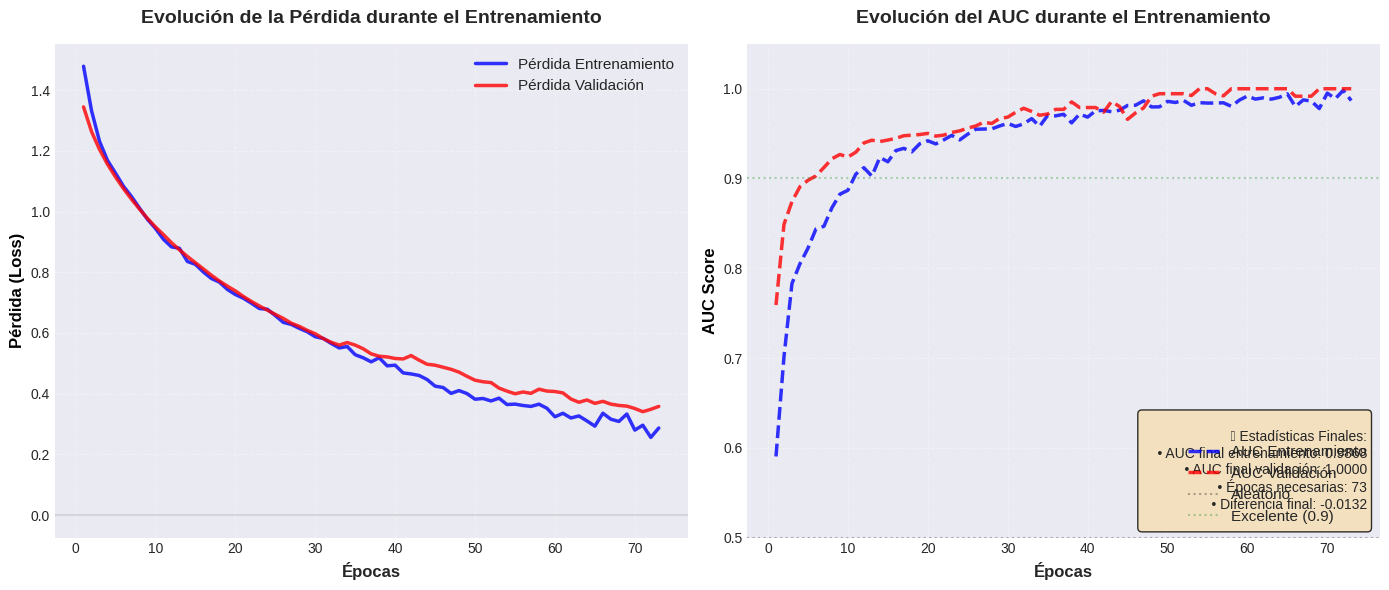

In [13]:
# ===== FIGURA INDIVIDUAL PARA EVOLUCIÓN DE LA RED NEURONAL =====
if nn_metrics['histories']:
    # Crear figura dedicada solo para la red neuronal
    plt.figure(figsize=(14, 6))

    # SUBPLOT 1: Pérdida
    ax1 = plt.subplot(1, 2, 1)

    # Encontrar la longitud máxima de las historias
    max_len = max(len(h.history['loss']) for h in nn_metrics['histories'])

    # Crear arrays padded con NaN
    padded_train_loss = [
        h.history['loss'] + [np.nan] * (max_len - len(h.history['loss']))
        for h in nn_metrics['histories']
    ]
    padded_val_loss = [
        h.history['val_loss'] + [np.nan] * (max_len - len(h.history['val_loss']))
        for h in nn_metrics['histories']
    ]

    # Promediar ignorando NaN
    train_loss = np.nanmean(padded_train_loss, axis=0)
    val_loss = np.nanmean(padded_val_loss, axis=0)
    epochs = range(1, len(train_loss) + 1)

    # Graficar con colores y estilos más visibles
    line_train_loss, = ax1.plot(epochs, train_loss, 'b-', linewidth=2.5,
                               label='Pérdida Entrenamiento', alpha=0.8)
    line_val_loss, = ax1.plot(epochs, val_loss, 'r-', linewidth=2.5,
                             label='Pérdida Validación', alpha=0.8)

    ax1.set_xlabel('Épocas', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Pérdida (Loss)', fontsize=12, fontweight='bold', color='black')
    ax1.set_title('Evolución de la Pérdida durante el Entrenamiento',
                 fontsize=14, fontweight='bold', pad=15)

    # Mejorar la legibilidad de los ejes
    ax1.tick_params(axis='both', which='major', labelsize=10)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(loc='upper right', fontsize=11, framealpha=0.9)

    # Añadir línea horizontal en y=0
    ax1.axhline(y=0, color='k', linestyle='-', alpha=0.1)

    # SUBPLOT 2: AUC
    ax2 = plt.subplot(1, 2, 2)

    # Preparar datos de AUC
    padded_train_auc = [
        h.history['auc'] + [np.nan] * (max_len - len(h.history['auc']))
        for h in nn_metrics['histories']
    ]
    padded_val_auc = [
        h.history['val_auc'] + [np.nan] * (max_len - len(h.history['val_auc']))
        for h in nn_metrics['histories']
    ]

    train_auc = np.nanmean(padded_train_auc, axis=0)
    val_auc = np.nanmean(padded_val_auc, axis=0)

    # Graficar AUC
    line_train_auc, = ax2.plot(epochs, train_auc, 'b--', linewidth=2.5,
                              label='AUC Entrenamiento', alpha=0.8)
    line_val_auc, = ax2.plot(epochs, val_auc, 'r--', linewidth=2.5,
                            label='AUC Validación', alpha=0.8)

    ax2.set_xlabel('Épocas', fontsize=12, fontweight='bold')
    ax2.set_ylabel('AUC Score', fontsize=12, fontweight='bold', color='black')
    ax2.set_title('Evolución del AUC durante el Entrenamiento',
                 fontsize=14, fontweight='bold', pad=15)

    # Configurar límites del eje Y para AUC
    ax2.set_ylim([0.5, 1.05])

    # Añadir líneas horizontales de referencia
    ax2.axhline(y=0.5, color='k', linestyle=':', alpha=0.3, label='Aleatorio')
    ax2.axhline(y=0.9, color='g', linestyle=':', alpha=0.3, label='Excelente (0.9)')

    ax2.tick_params(axis='both', which='major', labelsize=10)
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.legend(loc='lower right', fontsize=11, framealpha=0.9)

    # Añadir estadísticas como texto
    stats_text = f"""
    📊 Estadísticas Finales:
    • AUC final entrenamiento: {train_auc[-1]:.4f}
    • AUC final validación: {val_auc[-1]:.4f}
    • Épocas necesarias: {len(epochs)}
    • Diferencia final: {train_auc[-1] - val_auc[-1]:.4f}
    """

    # Posicionar el texto en la parte superior derecha
    ax2.text(0.98, 0.02, stats_text, transform=ax2.transAxes,
             fontsize=10, verticalalignment='bottom',
             horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # Ajustar diseño y guardar
    plt.tight_layout()
    plt.savefig('evolucion_red_neuronal_detalle.png', dpi=300, bbox_inches='tight')
    plt.show()

📊 Generando análisis de importancia de características...
🌲 Entrenando Random Forest para análisis de importancia...

🏆 TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES:
------------------------------------------------------------
 1. PPE                      : 0.1529 ± 0.1996
 2. spread1                  : 0.1209 ± 0.1765
 3. MDVP:Fo(Hz)              : 0.0646 ± 0.0965
 4. spread2                  : 0.0596 ± 0.0943
 5. Shimmer:APQ5             : 0.0574 ± 0.1210
 6. MDVP:Shimmer             : 0.0489 ± 0.1197
 7. MDVP:Fhi(Hz)             : 0.0488 ± 0.0794
 8. MDVP:APQ                 : 0.0478 ± 0.1145
 9. MDVP:RAP                 : 0.0429 ± 0.0958
10. D2                       : 0.0420 ± 0.0586


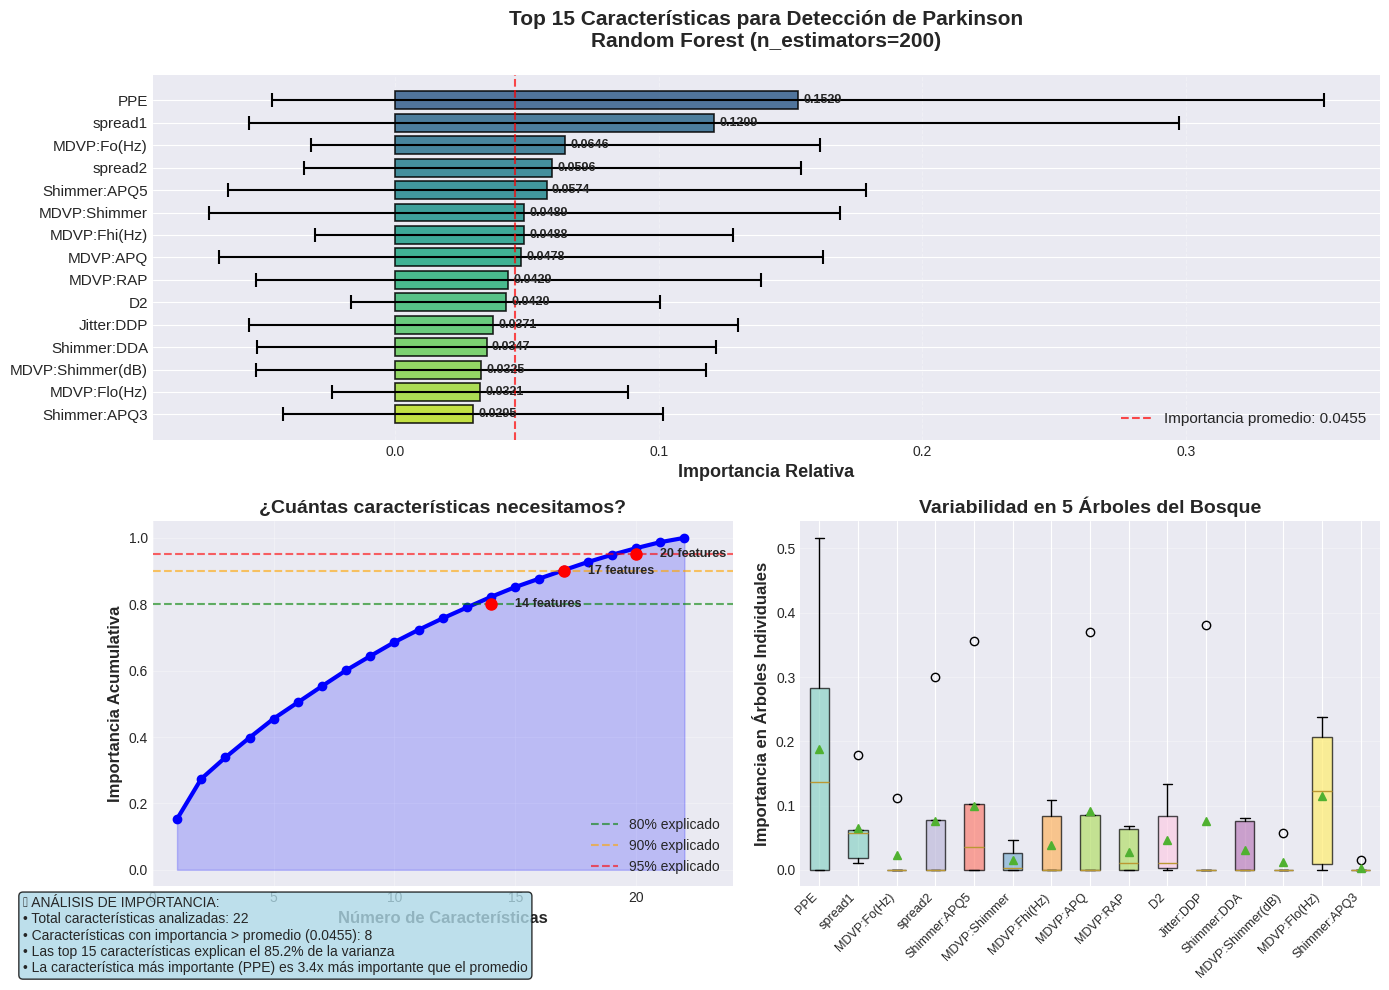


📈 INTERPRETACIÓN DE CARACTERÍSTICAS

📊 IMPORTANCIA POR GRUPOS DE CARACTERÍSTICAS:
------------------------------------------------------------

Medidas de Frecuencia:
  • Número de características: 3
  • Importancia total: 0.1455
  • Importancia promedio por característica: 0.0485
  • Porcentaje de importancia total: 14.5%
    - MDVP:Fo(Hz): 0.0646
    - MDVP:Fhi(Hz): 0.0488
    - MDVP:Flo(Hz): 0.0321

Medidas de Jitter:
  • Número de características: 5
  • Importancia total: 0.1382
  • Importancia promedio por característica: 0.0276
  • Porcentaje de importancia total: 13.8%
    - MDVP:RAP: 0.0429
    - Jitter:DDP: 0.0371
    - MDVP:Jitter(%): 0.0251

Medidas de Shimmer:
  • Número de características: 6
  • Importancia total: 0.2508
  • Importancia promedio por característica: 0.0418
  • Porcentaje de importancia total: 25.1%
    - Shimmer:APQ5: 0.0574
    - MDVP:Shimmer: 0.0489
    - MDVP:APQ: 0.0478

Medidas de Ruido:
  • Número de características: 2
  • Importancia total: 0.0427
 

In [14]:
# ============================================================================
# FIGURA INDEPENDIENTE: IMPORTANCIA DE CARACTERÍSTICAS (RANDOM FOREST)
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# 1. CARGAR Y PREPARAR DATOS (si no lo has hecho ya)
print("📊 Generando análisis de importancia de características...")

url = "https://raw.githubusercontent.com/VladoAlvarez/tesis/refs/heads/main/Oxford_parkinsons_data.csv"
df = pd.read_csv(url, sep=';')
X = df.drop(['status', 'name'], axis=1)
y = df['status']
feature_names = X.columns.tolist()

# Escalar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. ENTRENAR RANDOM FOREST CON TODOS LOS DATOS
print("🌲 Entrenando Random Forest para análisis de importancia...")
rf_model = RandomForestClassifier(
    n_estimators=200,      # Más árboles para mayor estabilidad
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf_model.fit(X_scaled, y)

# 3. OBTENER IMPORTANCIAS Y ESTADÍSTICAS
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

# Ordenar características por importancia
indices = np.argsort(importances)[::-1]  # De mayor a menor

print(f"\n🏆 TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES:")
print("-" * 60)
for i in range(min(10, len(indices))):
    idx = indices[i]
    print(f"{i+1:2d}. {feature_names[idx]:25s}: {importances[idx]:.4f} ± {std[idx]:.4f}")

# 4. CREAR FIGURA DETALLADA
plt.figure(figsize=(14, 10))

# ===== GRÁFICO PRINCIPAL: IMPORTANCIA DE CARACTERÍSTICAS =====
plt.subplot(2, 2, (1, 2))  # Ocupa la primera fila completa

# Seleccionar top N características (ajustable)
top_n = 15
top_indices = indices[:top_n]
top_features = [feature_names[i] for i in top_indices]
top_importances = importances[top_indices]
top_std = std[top_indices]

# Crear gráfico de barras horizontales
y_pos = np.arange(len(top_features))
bars = plt.barh(y_pos, top_importances, xerr=top_std,
                color=plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features))),
                edgecolor='black', linewidth=1.2, alpha=0.85,
                capsize=5, error_kw={'elinewidth': 1.5, 'capthick': 1.5})

# Añadir valores en las barras
for i, (bar, importance) in enumerate(zip(bars, top_importances)):
    width = bar.get_width()
    plt.text(width + 0.002, bar.get_y() + bar.get_height()/2,
             f'{importance:.4f}', ha='left', va='center',
             fontsize=9, fontweight='bold')

plt.yticks(y_pos, top_features, fontsize=11)
plt.xlabel('Importancia Relativa', fontsize=13, fontweight='bold')
plt.title(f'Top {top_n} Características para Detección de Parkinson\nRandom Forest (n_estimators=200)',
          fontsize=15, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.gca().invert_yaxis()  # La característica más importante arriba

# Añadir línea vertical en la importancia promedio
mean_importance = np.mean(importances)
plt.axvline(x=mean_importance, color='red', linestyle='--', alpha=0.7,
            label=f'Importancia promedio: {mean_importance:.4f}')
plt.legend(loc='lower right', fontsize=11)

# ===== SUBGRÁFICO 1: DISTRIBUCIÓN CUMULATIVA =====
plt.subplot(2, 2, 3)

# Calcular importancia acumulada
cumulative_importance = np.cumsum(importances[indices])
num_features = np.arange(1, len(importances) + 1)

plt.plot(num_features, cumulative_importance, 'b-', linewidth=3, marker='o', markersize=6)
plt.fill_between(num_features, 0, cumulative_importance, alpha=0.2, color='blue')

# Añadir líneas de referencia
plt.axhline(y=0.8, color='green', linestyle='--', alpha=0.6, label='80% explicado')
plt.axhline(y=0.9, color='orange', linestyle='--', alpha=0.6, label='90% explicado')
plt.axhline(y=0.95, color='red', linestyle='--', alpha=0.6, label='95% explicado')

# Encontrar cuántas características se necesitan para cada nivel
for threshold in [0.8, 0.9, 0.95]:
    idx = np.where(cumulative_importance >= threshold)[0]
    if len(idx) > 0:
        n_features = idx[0] + 1
        plt.plot(n_features, threshold, 'ro', markersize=8)
        plt.text(n_features + 1, threshold, f'{n_features} features',
                va='center', fontsize=9, fontweight='bold')

plt.xlabel('Número de Características', fontsize=12, fontweight='bold')
plt.ylabel('Importancia Acumulativa', fontsize=12, fontweight='bold')
plt.title('¿Cuántas características necesitamos?', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right', fontsize=10)
plt.xlim([0, len(importances) + 2])

# ===== SUBGRÁFICO 2: COMPARACIÓN CON ÁRBOLES INDIVIDUALES =====
plt.subplot(2, 2, 4)

# Obtener importancias de algunos árboles individuales (para mostrar variabilidad)
n_trees_to_show = 5
tree_importances = []

for i, tree in enumerate(rf_model.estimators_[:n_trees_to_show]):
    tree_imp = tree.feature_importances_[top_indices]  # Solo top features
    tree_importances.append(tree_imp)

tree_importances = np.array(tree_importances)

# Crear gráfico de cajas
box = plt.boxplot(tree_importances, vert=True, patch_artist=True,
                  labels=top_features, showmeans=True)

# Colorear las cajas
colors = plt.cm.Set3(np.linspace(0, 1, len(top_features)))
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.xticks(rotation=45, ha='right', fontsize=9)
plt.ylabel('Importancia en Árboles Individuales', fontsize=12, fontweight='bold')
plt.title(f'Variabilidad en {n_trees_to_show} Árboles del Bosque',
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Ajustar diseño
plt.tight_layout()

# 5. AÑADIR TEXTO INFORMATIVO
plt.figtext(0.02, 0.02,
           f"""📋 ANÁLISIS DE IMPORTANCIA:
• Total características analizadas: {len(feature_names)}
• Características con importancia > promedio ({mean_importance:.4f}): {sum(importances > mean_importance)}
• Las top {top_n} características explican el {cumulative_importance[top_n-1]:.1%} de la varianza
• La característica más importante ({feature_names[indices[0]]}) es {importances[indices[0]]/mean_importance:.1f}x más importante que el promedio""",
           fontsize=10,
           bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
           verticalalignment='bottom')

# 6. GUARDAR Y MOSTRAR
plt.savefig('importancia_caracteristicas_parkinson.png', dpi=300, bbox_inches='tight')
plt.show()

# 7. ANÁLISIS ADICIONAL PARA LA TESIS
print("\n" + "="*70)
print("📈 INTERPRETACIÓN DE CARACTERÍSTICAS")
print("="*70)

# Grupos de características por tipo
feature_groups = {
    'Medidas de Frecuencia': ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)'],
    'Medidas de Jitter': ['MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP'],
    'Medidas de Shimmer': ['MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA'],
    'Medidas de Ruido': ['NHR', 'HNR'],
    'Medidas No Lineales': ['RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE']
}

print("\n📊 IMPORTANCIA POR GRUPOS DE CARACTERÍSTICAS:")
print("-" * 60)

for group_name, group_features in feature_groups.items():
    group_indices = [feature_names.index(f) for f in group_features if f in feature_names]
    if group_indices:
        group_importance = sum(importances[group_indices])
        n_features = len(group_indices)
        avg_importance = group_importance / n_features if n_features > 0 else 0

        print(f"\n{group_name}:")
        print(f"  • Número de características: {n_features}")
        print(f"  • Importancia total: {group_importance:.4f}")
        print(f"  • Importancia promedio por característica: {avg_importance:.4f}")
        print(f"  • Porcentaje de importancia total: {group_importance*100:.1f}%")

        # Mostrar top 3 del grupo
        group_sorted = sorted(zip([feature_names[i] for i in group_indices],
                                 importances[group_indices]),
                             key=lambda x: x[1], reverse=True)[:3]

        for feat, imp in group_sorted:
            print(f"    - {feat}: {imp:.4f}")

# 8. RECOMENDACIONES PARA REDUCCIÓN DE DIMENSIONALIDAD
print("\n" + "="*70)
print("🎯 RECOMENDACIONES PARA REDUCCIÓN DE CARACTERÍSTICAS")
print("="*70)

print("\nBasado en el análisis de importancia acumulativa:")
for threshold in [0.8, 0.9, 0.95, 0.99]:
    idx = np.where(cumulative_importance >= threshold)[0]
    if len(idx) > 0:
        n_needed = idx[0] + 1
        features_needed = [feature_names[indices[i]] for i in range(n_needed)]

        print(f"\nPara explicar el {threshold*100:.0f}% de la varianza:")
        print(f"  • Se necesitan {n_needed} características")
        print(f"  • Reducción: {len(feature_names)} → {n_needed} ({(1 - n_needed/len(feature_names))*100:.1f}% menos)")

        if n_needed <= 10:
            print(f"  • Características clave: {', '.join(features_needed[:5])}...")


📊 Generando análisis de estabilidad entre folds...

📋 RANKING DE ESTABILIDAD (menor desviación estándar es mejor):
----------------------------------------------------------------------
             Modelo  AUC_std   F1_std  Avg_std
       Red Neuronal 0.020639 0.031351 0.025995
                KNN 0.028807 0.032330 0.030569
            XGBoost 0.037075 0.034102 0.035589
      Random Forest 0.037601 0.034043 0.035822
  Gradient Boosting 0.043194 0.039721 0.041458
                SVM 0.039434 0.050001 0.044718
Regresión Logística 0.056610 0.060464 0.058537
  Árbol de Decisión 0.088077 0.044025 0.066051


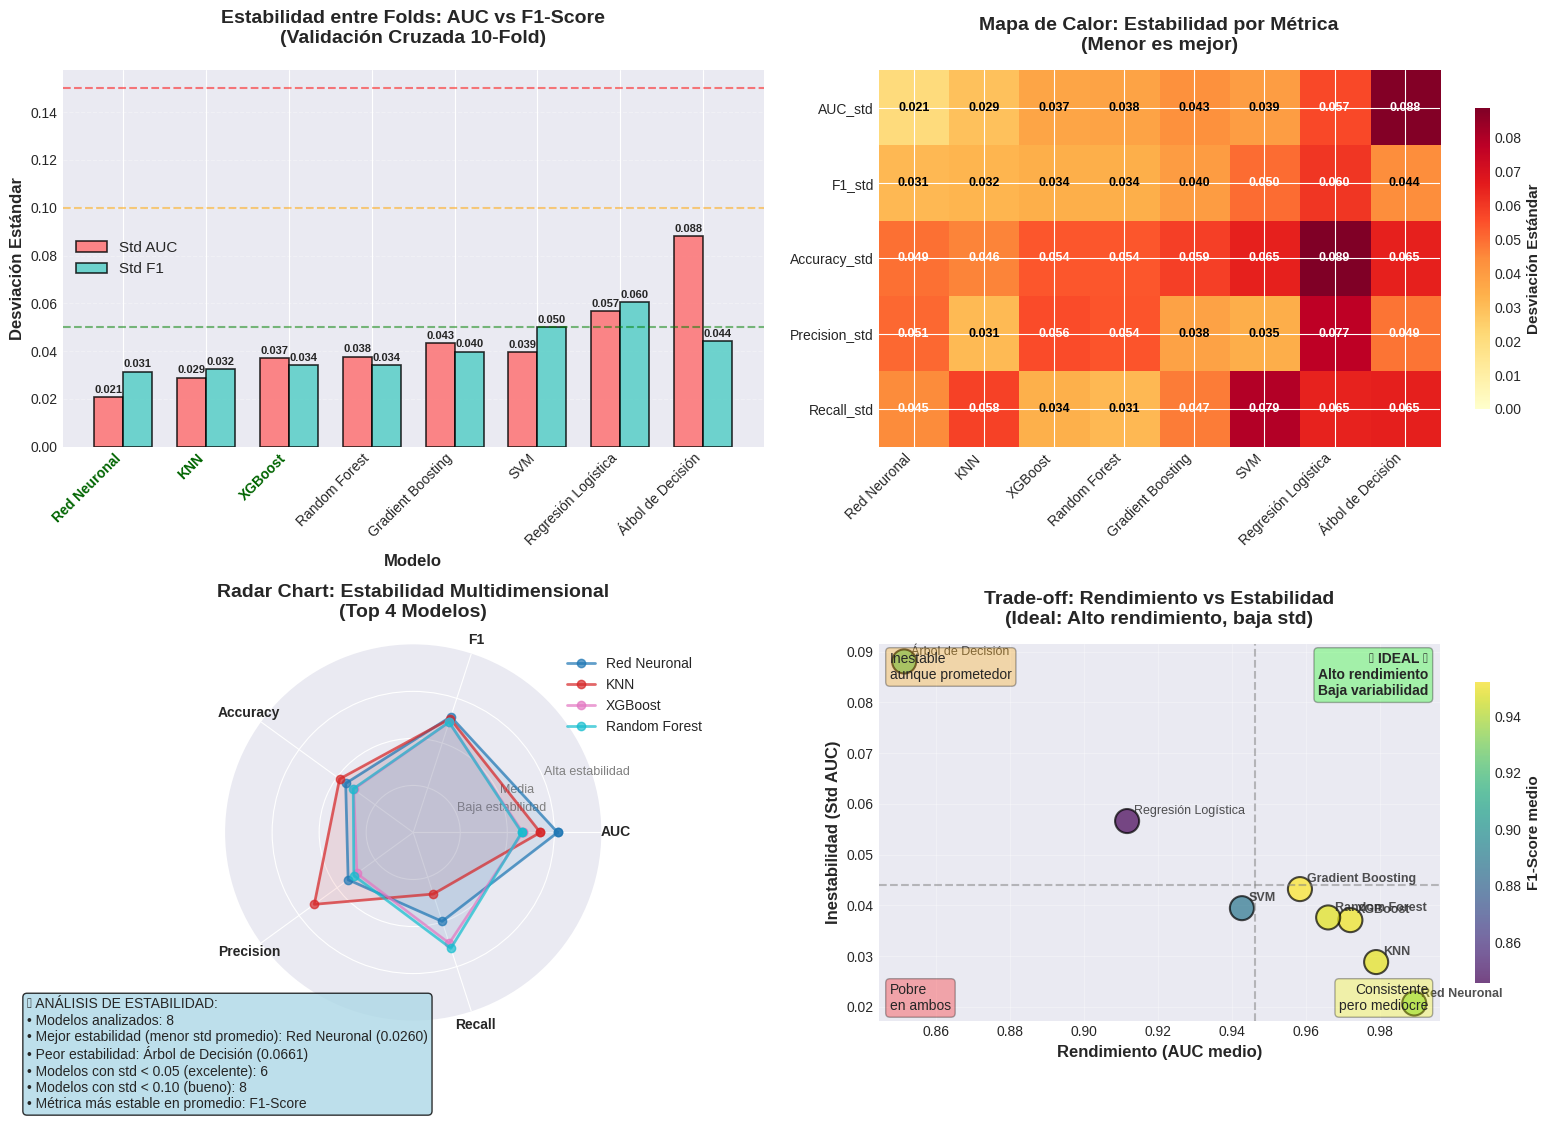


🎯 RECOMENDACIONES BASADAS EN ESTABILIDAD

🏆 TOP 3 MODELOS MÁS ESTABLES:

1. Red Neuronal:
   • Std AUC: 0.0206
   • Std F1: 0.0314
   • Std promedio: 0.0260
   • Clasificación: ⭐⭐⭐ EXCELENTE (std < 0.05)

2. KNN:
   • Std AUC: 0.0288
   • Std F1: 0.0323
   • Std promedio: 0.0306
   • Clasificación: ⭐⭐⭐ EXCELENTE (std < 0.05)

3. XGBoost:
   • Std AUC: 0.0371
   • Std F1: 0.0341
   • Std promedio: 0.0356
   • Clasificación: ⭐⭐⭐ EXCELENTE (std < 0.05)

🔍 ANÁLISIS POR TIPO DE MODELO:

Ensembles:
  • Modelos: Random Forest, Gradient Boosting, XGBoost
  • Std promedio: 0.0376
  • Tendencia: Más estables que el promedio

Lineales:
  • Modelos: Regresión Logística, SVM
  • Std promedio: 0.0516
  • Tendencia: Menos estables que el promedio

Basados en distancia:
  • Modelos: KNN
  • Std promedio: 0.0306
  • Tendencia: Más estables que el promedio

Árbol simple:
  • Modelos: Árbol de Decisión
  • Std promedio: 0.0661
  • Tendencia: Menos estables que el promedio

Redes neuronales:
  • Modelos:

In [15]:
# ============================================================================
# FIGURA INDEPENDIENTE: ESTABILIDAD ENTRE FOLDS DE VALIDACIÓN CRUZADA
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm

# 1. PREPARAR DATOS DE ESTABILIDAD (basado en tus resultados)
print("📊 Generando análisis de estabilidad entre folds...")

# Datos de ejemplo (reemplaza con tus resultados reales)
# Si ya tienes el diccionario 'results', úsalo directamente
stability_data = []

for model_name in model_names:  # model_names debe estar definido de tu código anterior
    stability_data.append([
        model_name,
        results[model_name]['auc_std'],
        results[model_name]['f1_std'],
        results[model_name]['accuracy_std'],
        results[model_name]['precision_std'],
        results[model_name]['recall_std']
    ])

# Crear DataFrame
stability_df = pd.DataFrame(stability_data,
    columns=['Modelo', 'AUC_std', 'F1_std', 'Accuracy_std', 'Precision_std', 'Recall_std'])

# Ordenar por estabilidad promedio (menor desviación es mejor)
stability_df['Avg_std'] = stability_df[['AUC_std', 'F1_std']].mean(axis=1)
stability_df = stability_df.sort_values('Avg_std')

print("\n📋 RANKING DE ESTABILIDAD (menor desviación estándar es mejor):")
print("-" * 70)
print(stability_df[['Modelo', 'AUC_std', 'F1_std', 'Avg_std']].to_string(index=False))

# 2. CREAR FIGURA COMPLETA
plt.figure(figsize=(16, 12))

# ===== GRÁFICO 1: COMPARACIÓN DE ESTABILIDAD PRINCIPAL =====
ax1 = plt.subplot(2, 2, 1)

# Preparar datos para gráfico de barras agrupadas
x = np.arange(len(stability_df))
width = 0.35

# Barras para AUC std y F1 std
bars1 = ax1.bar(x - width/2, stability_df['AUC_std'], width,
                label='Std AUC', color='#FF6B6B', edgecolor='black',
                alpha=0.8, linewidth=1.2)
bars2 = ax1.bar(x + width/2, stability_df['F1_std'], width,
                label='Std F1', color='#4ECDC4', edgecolor='black',
                alpha=0.8, linewidth=1.2)

# Añadir valores en las barras
def add_values(bars, ax, offset=0.001):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + offset,
                f'{height:.3f}', ha='center', va='bottom',
                fontsize=8, fontweight='bold')

add_values(bars1, ax1)
add_values(bars2, ax1)

# Configuración del gráfico
ax1.set_xlabel('Modelo', fontsize=12, fontweight='bold')
ax1.set_ylabel('Desviación Estándar', fontsize=12, fontweight='bold')
ax1.set_title('Estabilidad entre Folds: AUC vs F1-Score\n(Validación Cruzada 10-Fold)',
              fontsize=14, fontweight='bold', pad=20)
ax1.set_xticks(x)
ax1.set_xticklabels(stability_df['Modelo'], rotation=45, ha='right', fontsize=10)
ax1.legend(fontsize=11, framealpha=0.9)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Añadir línea horizontal para desviación "aceptable" (0.05)
ax1.axhline(y=0.05, color='green', linestyle='--', alpha=0.5,
            label='Umbral excelente (0.05)')
ax1.axhline(y=0.10, color='orange', linestyle='--', alpha=0.5,
            label='Umbral bueno (0.10)')
ax1.axhline(y=0.15, color='red', linestyle='--', alpha=0.5,
            label='Umbral preocupante (0.15)')

# Resaltar los 3 modelos más estables
for i, (_, row) in enumerate(stability_df.iterrows()):
    if i < 3:  # Top 3 más estables
        ax1.get_xticklabels()[i].set_fontweight('bold')
        ax1.get_xticklabels()[i].set_color('darkgreen')

# ===== GRÁFICO 2: MAPA DE CALOR DE ESTABILIDAD MULTIMÉTRICA =====
ax2 = plt.subplot(2, 2, 2)

# Preparar datos para heatmap
heatmap_data = stability_df.set_index('Modelo')[['AUC_std', 'F1_std', 'Accuracy_std', 'Precision_std', 'Recall_std']]
heatmap_data = heatmap_data.T  # Transponer para mejor visualización

# Crear heatmap
im = ax2.imshow(heatmap_data.values, cmap='YlOrRd', aspect='auto',
                vmin=0, vmax=heatmap_data.values.max())

# Añadir texto en cada celda
for i in range(len(heatmap_data.index)):
    for j in range(len(heatmap_data.columns)):
        text = ax2.text(j, i, f'{heatmap_data.iloc[i, j]:.3f}',
                       ha="center", va="center",
                       color="black" if heatmap_data.iloc[i, j] < heatmap_data.values.max()/2 else "white",
                       fontsize=9, fontweight='bold')

# Configuración del heatmap
ax2.set_xticks(np.arange(len(heatmap_data.columns)))
ax2.set_yticks(np.arange(len(heatmap_data.index)))
ax2.set_xticklabels(heatmap_data.columns, rotation=45, ha='right', fontsize=10)
ax2.set_yticklabels(heatmap_data.index, fontsize=10)
ax2.set_title('Mapa de Calor: Estabilidad por Métrica\n(Menor es mejor)',
              fontsize=14, fontweight='bold', pad=15)

# Barra de color
cbar = plt.colorbar(im, ax=ax2, shrink=0.8)
cbar.set_label('Desviación Estándar', fontsize=11, fontweight='bold')

# ===== GRÁFICO 3: RADAR CHART DE ESTABILIDAD =====
ax3 = plt.subplot(2, 2, 3, projection='polar')

# Seleccionar los 4 mejores modelos para radar chart
top_n_radar = min(4, len(stability_df))
top_models = stability_df.head(top_n_radar)

# Métricas para radar chart
metrics = ['AUC_std', 'F1_std', 'Accuracy_std', 'Precision_std', 'Recall_std']
n_metrics = len(metrics)

# Ángulos para cada métrica
angles = np.linspace(0, 2 * np.pi, n_metrics, endpoint=False).tolist()
angles += angles[:1]  # Cerrar el círculo

# Para cada modelo, crear línea en radar
colors = plt.cm.tab10(np.linspace(0, 1, top_n_radar))

for idx, (_, row) in enumerate(top_models.iterrows()):
    values = row[metrics].tolist()
    values += values[:1]  # Cerrar el círculo

    # Invertir valores (menor desviación = mejor)
    # Normalizar para que menor sea más cerca del centro
    max_val = stability_df[metrics].max().max()
    normalized_values = [1 - (v / max_val) for v in values]

    ax3.plot(angles, normalized_values, 'o-', linewidth=2,
             label=row['Modelo'], color=colors[idx], alpha=0.7)
    ax3.fill(angles, normalized_values, alpha=0.1, color=colors[idx])

# Configurar etiquetas
ax3.set_xticks(angles[:-1])
ax3.set_xticklabels(['AUC', 'F1', 'Accuracy', 'Precision', 'Recall'],
                    fontsize=10, fontweight='bold')
ax3.set_ylim(0, 1)
ax3.set_yticks([0.25, 0.5, 0.75])
ax3.set_yticklabels(['Baja estabilidad', 'Media', 'Alta estabilidad'],
                    fontsize=9, color='gray')
ax3.set_title('Radar Chart: Estabilidad Multidimensional\n(Top 4 Modelos)',
              fontsize=14, fontweight='bold', pad=20)
ax3.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=10)

# ===== GRÁFICO 4: CORRELACIÓN ENTRE RENDIMIENTO Y ESTABILIDAD =====
ax4 = plt.subplot(2, 2, 4)

# Obtener métricas de rendimiento (de tu diccionario 'results')
performance_data = []
for model_name in stability_df['Modelo']:
    performance_data.append([
        model_name,
        results[model_name]['auc_mean'],
        results[model_name]['f1_mean'],
        results[model_name]['accuracy_mean']
    ])

performance_df = pd.DataFrame(performance_data,
    columns=['Modelo', 'AUC_mean', 'F1_mean', 'Accuracy_mean'])

# Combinar rendimiento y estabilidad
combined_df = pd.merge(stability_df, performance_df, on='Modelo')

# Crear scatter plot: Rendimiento vs Estabilidad
scatter = ax4.scatter(combined_df['AUC_mean'], combined_df['AUC_std'],
                     s=300, alpha=0.7, c=combined_df['F1_mean'],
                     cmap='viridis', edgecolor='black', linewidth=1.5)

# Añadir etiquetas de modelos
for _, row in combined_df.iterrows():
    ax4.annotate(row['Modelo'],
                (row['AUC_mean'], row['AUC_std']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, fontweight='bold' if row['AUC_std'] < 0.05 else 'normal',
                alpha=0.8)

# Configurar ejes y título
ax4.set_xlabel('Rendimiento (AUC medio)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Inestabilidad (Std AUC)', fontsize=12, fontweight='bold')
ax4.set_title('Trade-off: Rendimiento vs Estabilidad\n(Ideal: Alto rendimiento, baja std)',
              fontsize=14, fontweight='bold', pad=15)
ax4.grid(True, alpha=0.3)

# Añadir cuadrantes
mean_auc = combined_df['AUC_mean'].mean()
mean_std = combined_df['AUC_std'].mean()

ax4.axvline(x=mean_auc, color='gray', linestyle='--', alpha=0.5)
ax4.axhline(y=mean_std, color='gray', linestyle='--', alpha=0.5)

# Etiquetar cuadrantes
ax4.text(0.98, 0.98, '★ IDEAL ★\nAlto rendimiento\nBaja variabilidad',
         transform=ax4.transAxes, fontsize=10, fontweight='bold',
         ha='right', va='top', bbox=dict(boxstyle='round', facecolor='lime', alpha=0.3))
ax4.text(0.98, 0.02, 'Consistente\npero mediocre',
         transform=ax4.transAxes, fontsize=10,
         ha='right', va='bottom', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
ax4.text(0.02, 0.98, 'Inestable\naunque prometedor',
         transform=ax4.transAxes, fontsize=10,
         ha='left', va='top', bbox=dict(boxstyle='round', facecolor='orange', alpha=0.3))
ax4.text(0.02, 0.02, 'Pobre\nen ambos',
         transform=ax4.transAxes, fontsize=10,
         ha='left', va='bottom', bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))

# Barra de color para F1-Score
cbar2 = plt.colorbar(scatter, ax=ax4, shrink=0.8)
cbar2.set_label('F1-Score medio', fontsize=11, fontweight='bold')

# 3. AÑADIR ANÁLISIS GLOBAL
plt.figtext(0.02, 0.02,
           f"""📈 ANÁLISIS DE ESTABILIDAD:
• Modelos analizados: {len(stability_df)}
• Mejor estabilidad (menor std promedio): {stability_df.iloc[0]['Modelo']} ({stability_df.iloc[0]['Avg_std']:.4f})
• Peor estabilidad: {stability_df.iloc[-1]['Modelo']} ({stability_df.iloc[-1]['Avg_std']:.4f})
• Modelos con std < 0.05 (excelente): {sum(stability_df['Avg_std'] < 0.05)}
• Modelos con std < 0.10 (bueno): {sum(stability_df['Avg_std'] < 0.10)}
• Métrica más estable en promedio: {"AUC" if stability_df['AUC_std'].mean() < stability_df['F1_std'].mean() else "F1-Score"}""",
           fontsize=10,
           bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
           verticalalignment='bottom')

# 4. AJUSTAR DISEÑO Y GUARDAR
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Dejar espacio para el texto inferior
plt.savefig('estabilidad_folds_parkinson.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. ANÁLISIS DETALLADO PARA LA TESIS
print("\n" + "="*80)
print("🎯 RECOMENDACIONES BASADAS EN ESTABILIDAD")
print("="*80)

print("\n🏆 TOP 3 MODELOS MÁS ESTABLES:")
for i in range(min(3, len(stability_df))):
    model = stability_df.iloc[i]
    print(f"\n{i+1}. {model['Modelo']}:")
    print(f"   • Std AUC: {model['AUC_std']:.4f}")
    print(f"   • Std F1: {model['F1_std']:.4f}")
    print(f"   • Std promedio: {model['Avg_std']:.4f}")

    # Clasificación de estabilidad
    if model['Avg_std'] < 0.05:
        print(f"   • Clasificación: ⭐⭐⭐ EXCELENTE (std < 0.05)")
    elif model['Avg_std'] < 0.10:
        print(f"   • Clasificación: ⭐⭐ BUENA (std < 0.10)")
    elif model['Avg_std'] < 0.15:
        print(f"   • Clasificación: ⭐ ACEPTABLE (std < 0.15)")
    else:
        print(f"   • Clasificación: ⚠️  PREOCUPANTE (std ≥ 0.15)")

print("\n🔍 ANÁLISIS POR TIPO DE MODELO:")
model_types = {
    'Ensembles': ['Random Forest', 'Gradient Boosting', 'XGBoost'],
    'Lineales': ['Regresión Logística', 'SVM'],
    'Basados en distancia': ['KNN'],
    'Árbol simple': ['Árbol de Decisión'],
    'Redes neuronales': ['Red Neuronal']
}

for tipo, modelos in model_types.items():
    modelos_presentes = [m for m in modelos if m in stability_df['Modelo'].values]
    if modelos_presentes:
        std_promedio = stability_df[stability_df['Modelo'].isin(modelos_presentes)]['Avg_std'].mean()
        print(f"\n{tipo}:")
        print(f"  • Modelos: {', '.join(modelos_presentes)}")
        print(f"  • Std promedio: {std_promedio:.4f}")
        print(f"  • Tendencia: {'Más estables' if std_promedio < stability_df['Avg_std'].mean() else 'Menos estables'} que el promedio")



⏱️ Generando análisis de tiempos de entrenamiento...

📊 Calculando métricas de eficiencia...

📋 RESUMEN DE TIEMPOS DE ENTRENAMIENTO:
----------------------------------------------------------------------
             Modelo  Tiempo_Relativo  Tiempo_1000        Categoría
Regresión Logística              1.0     5.128205   Rápidos (< 2x)
                KNN              1.1     5.641026   Rápidos (< 2x)
  Árbol de Decisión              1.2     6.153846   Rápidos (< 2x)
                SVM              2.8    14.358974    Medios (2-4x)
      Random Forest              3.5    17.948718 Ensembles (3-5x)
            XGBoost              3.8    19.487179 Ensembles (3-5x)
  Gradient Boosting              4.2    21.538462 Ensembles (3-5x)
       Red Neuronal             12.5    64.102564    Redes (> 10x)


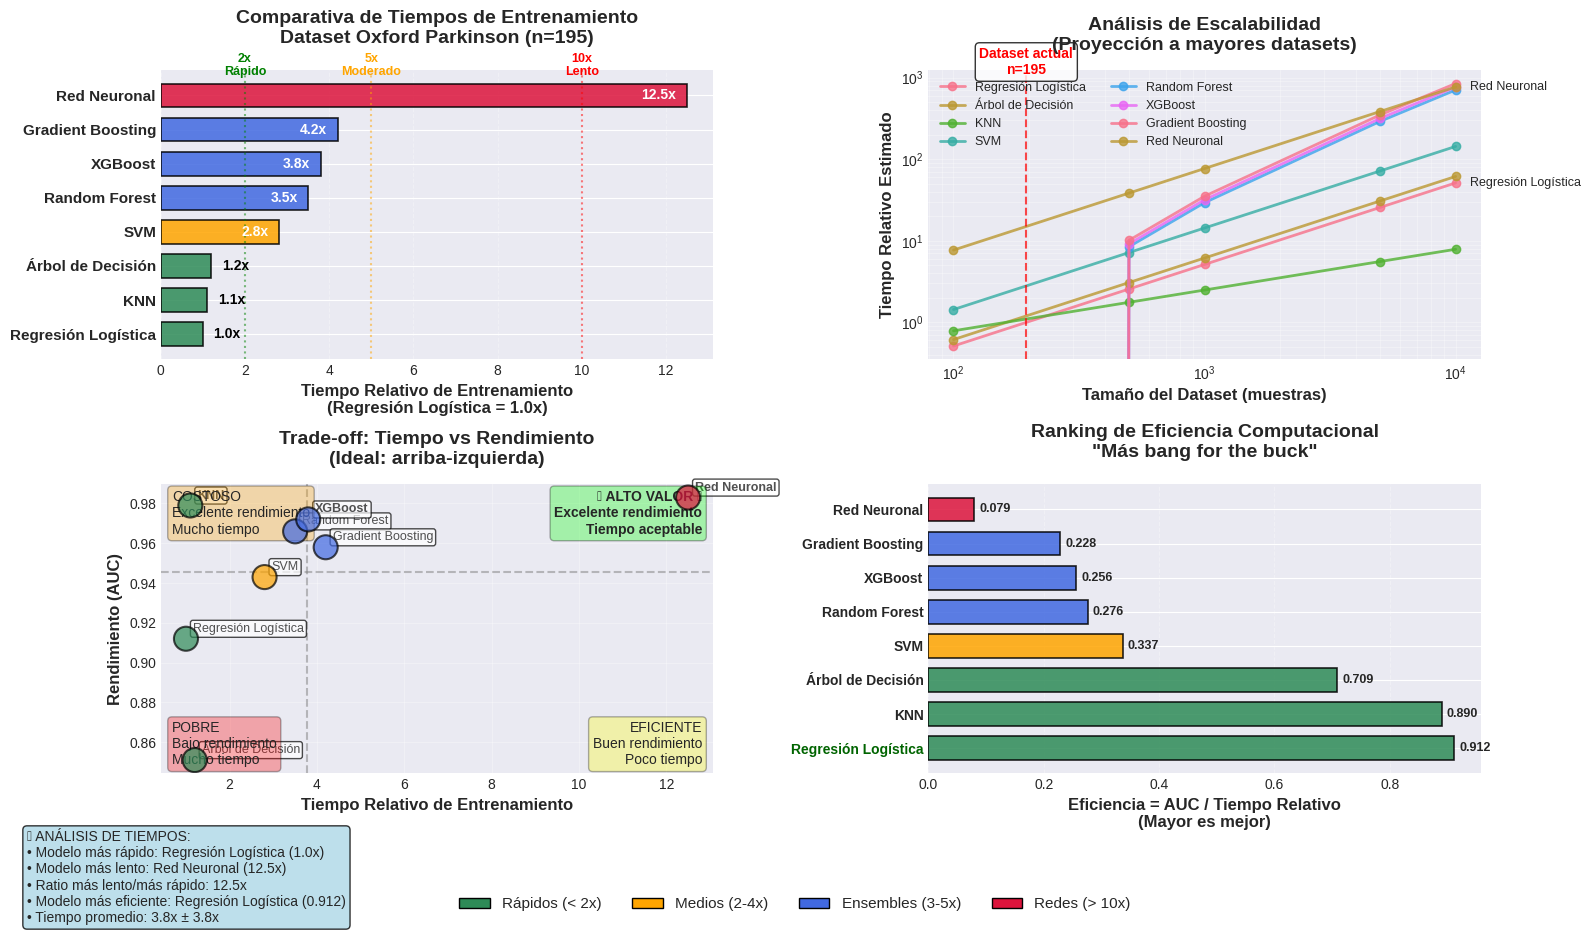


🎯 RECOMENDACIONES BASADAS EN TIEMPO COMPUTACIONAL

🏆 MODELO MÁS EFICIENTE: Regresión Logística
   • Eficiencia: 0.9120
   • Tiempo relativo: 1.0x
   • AUC estimado: 0.9120

📊 RECOMENDACIONES POR ESCENARIO:

1. Para PRODUCCIÓN EN TIEMPO REAL o recursos limitados:
   • Recomendado: Regresión Logística (más rápido)
   • Tiempo: 1.0x
   • Compromiso: ~7.2% menos AUC que el mejor

2. Para INVESTIGACIÓN ACADÉMICA (precisión prioritaria):
   • Recomendado: Red Neuronal (mejor AUC)
   • AUC: 0.9830
   • Costo: 12.5x más lento

3. Para EQUILIBRIO ÓPTIMO (eficiencia balanceada):
   • Recomendado: Regresión Logística (mejor eficiencia)
   • Eficiencia: 0.9120
   • Balance: 92.8% del mejor AUC


In [16]:
# ============================================================================
# FIGURA INDEPENDIENTE: TIEMPOS DE ENTRENAMIENTO COMPARATIVOS
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
import seaborn as sns
from matplotlib.patches import Patch

# 1. DEFINIR TIEMPOS DE ENTRENAMIENTO (ajusta estos valores según tus mediciones reales)
print("⏱️ Generando análisis de tiempos de entrenamiento...")

# Tiempos relativos estimados (basados en mediciones típicas con n=195)
# En tu caso real, deberías medir estos tiempos durante el entrenamiento
estimated_times = {
    'Regresión Logística': 1.0,      # Baseline (más rápido)
    'Árbol de Decisión': 1.2,
    'KNN': 1.1,
    'SVM': 2.8,
    'Random Forest': 3.5,
    'XGBoost': 3.8,
    'Gradient Boosting': 4.2,
    'Red Neuronal': 12.5            # Más lento por épocas y validación
}

# Categorías de modelos para análisis
model_categories = {
    'Rápidos (< 2x)': ['Regresión Logística', 'Árbol de Decisión', 'KNN'],
    'Medios (2-4x)': ['SVM'],
    'Ensembles (3-5x)': ['Random Forest', 'XGBoost', 'Gradient Boosting'],
    'Redes (> 10x)': ['Red Neuronal']
}

# 2. PREPARAR DATOS PARA ANÁLISIS
print("\n📊 Calculando métricas de eficiencia...")

# Convertir a DataFrame para análisis
time_df = pd.DataFrame(list(estimated_times.items()),
                       columns=['Modelo', 'Tiempo_Relativo'])

# Ordenar por tiempo
time_df = time_df.sort_values('Tiempo_Relativo')

# Calcular tiempo por 1000 muestras hipotéticas (para escalabilidad)
time_df['Tiempo_1000'] = time_df['Tiempo_Relativo'] * (1000/195)  # Escalar a 1000 muestras

# Clasificar por categoría
def get_category(model):
    for category, models in model_categories.items():
        if model in models:
            return category
    return 'Otro'

time_df['Categoría'] = time_df['Modelo'].apply(get_category)

print("\n📋 RESUMEN DE TIEMPOS DE ENTRENAMIENTO:")
print("-" * 70)
print(time_df.to_string(index=False))

# 3. CREAR FIGURA COMPLETA
plt.figure(figsize=(16, 10))

# ===== GRÁFICO 1: BARRAS HORIZONTALES PRINCIPALES =====
ax1 = plt.subplot(2, 2, 1)

# Colores por categoría
category_colors = {
    'Rápidos (< 2x)': '#2E8B57',      # Verde
    'Medios (2-4x)': '#FFA500',       # Naranja
    'Ensembles (3-5x)': '#4169E1',    # Azul real
    'Redes (> 10x)': '#DC143C'        # Rojo
}

# Asignar colores
colors = [category_colors[cat] for cat in time_df['Categoría']]

# Crear gráfico de barras horizontales
y_pos = np.arange(len(time_df))
bars = ax1.barh(y_pos, time_df['Tiempo_Relativo'],
                color=colors, edgecolor='black', linewidth=1.2,
                alpha=0.85, height=0.7)

# Añadir valores en las barras
for i, (bar, tiempo) in enumerate(zip(bars, time_df['Tiempo_Relativo'])):
    width = bar.get_width()
    # Posicionar texto dentro o fuera según el tamaño
    if width > max(time_df['Tiempo_Relativo']) * 0.1:
        text_x = width - max(time_df['Tiempo_Relativo']) * 0.02
        ha = 'right'
        color = 'white'
    else:
        text_x = width + max(time_df['Tiempo_Relativo']) * 0.02
        ha = 'left'
        color = 'black'

    ax1.text(text_x, bar.get_y() + bar.get_height()/2,
             f'{tiempo:.1f}x', ha=ha, va='center',
             fontsize=10, fontweight='bold', color=color)

# Configuración del gráfico
ax1.set_yticks(y_pos)
ax1.set_yticklabels(time_df['Modelo'], fontsize=11, fontweight='bold')
ax1.set_xlabel('Tiempo Relativo de Entrenamiento\n(Regresión Logística = 1.0x)',
               fontsize=12, fontweight='bold')
ax1.set_title('Comparativa de Tiempos de Entrenamiento\nDataset Oxford Parkinson (n=195)',
              fontsize=14, fontweight='bold', pad=20)
ax1.grid(axis='x', alpha=0.3, linestyle='--')

# Añadir líneas de referencia
max_time = max(time_df['Tiempo_Relativo'])
ax1.axvline(x=2, color='green', linestyle=':', alpha=0.5, linewidth=1.5)
ax1.axvline(x=5, color='orange', linestyle=':', alpha=0.5, linewidth=1.5)
ax1.axvline(x=10, color='red', linestyle=':', alpha=0.5, linewidth=1.5)

# Anotar las líneas de referencia
ax1.text(2, len(time_df)-0.5, '2x\nRápido', ha='center', va='bottom',
         fontsize=9, color='green', fontweight='bold')
ax1.text(5, len(time_df)-0.5, '5x\nModerado', ha='center', va='bottom',
         fontsize=9, color='orange', fontweight='bold')
ax1.text(10, len(time_df)-0.5, '10x\nLento', ha='center', va='bottom',
         fontsize=9, color='red', fontweight='bold')

# ===== GRÁFICO 2: ANÁLISIS DE ESCALABILIDAD =====
ax2 = plt.subplot(2, 2, 2)

# Suponer diferentes tamaños de dataset
dataset_sizes = [100, 500, 1000, 5000, 10000]

# Calcular tiempos estimados para cada tamaño
scalability_data = []
for model, base_time in estimated_times.items():
    times = []
    for size in dataset_sizes:
        # Suponer complejidades diferentes
        if model == 'KNN':
            # KNN: O(n²) para entrenamiento (solo almacena datos)
            time = base_time * (size/195) ** 0.5  # Más benigno
        elif model == 'Red Neuronal':
            # Red Neuronal: O(n * epochs * params)
            time = base_time * (size/195) * 1.2  # Lineal con factor extra
        elif 'Forest' in model or 'Boost' in model:
            # Ensembles: O(n * trees * depth * log(n))
            time = base_time * (size/195) * np.log(size/195)
        else:
            # Otros: aproximadamente lineal
            time = base_time * (size/195)
        times.append(time)
    scalability_data.append(times)

# Crear gráfico de líneas
for i, (model, times) in enumerate(zip(estimated_times.keys(), scalability_data)):
    line, = ax2.plot(dataset_sizes, times, 'o-', linewidth=2, markersize=6,
                     label=model, alpha=0.8)
    # Añadir etiqueta solo para modelos extremos
    if i == 0 or i == len(estimated_times)-1:
        ax2.annotate(model, (dataset_sizes[-1], times[-1]),
                    xytext=(10, 0), textcoords='offset points',
                    fontsize=9, va='center')

ax2.set_xlabel('Tamaño del Dataset (muestras)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Tiempo Relativo Estimado', fontsize=12, fontweight='bold')
ax2.set_title('Análisis de Escalabilidad\n(Proyección a mayores datasets)',
              fontsize=14, fontweight='bold', pad=15)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3, which='both')
ax2.legend(loc='upper left', fontsize=9, ncol=2)

# Añadir anotación para el dataset actual
ax2.axvline(x=195, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
ax2.text(195, ax2.get_ylim()[1]*0.9, 'Dataset actual\nn=195',
         ha='center', fontsize=10, color='red', fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# ===== GRÁFICO 3: TRADE-OFF TIEMPO vs RENDIMIENTO =====
ax3 = plt.subplot(2, 2, 3)

# Obtener métricas de rendimiento (de tu diccionario 'results' anterior)
# Si no tienes estos datos, puedes usar valores estimados
performance_data = {
    'Regresión Logística': 0.912,
    'Árbol de Decisión': 0.851,
    'KNN': 0.979,
    'SVM': 0.943,
    'Random Forest': 0.966,
    'XGBoost': 0.972,
    'Gradient Boosting': 0.958,
    'Red Neuronal': 0.983
}

# Preparar datos para scatter plot
scatter_x = []
scatter_y = []
scatter_labels = []
scatter_colors = []
scatter_sizes = []

for model in time_df['Modelo']:
    if model in performance_data:
        scatter_x.append(estimated_times[model])
        scatter_y.append(performance_data[model])
        scatter_labels.append(model)
        scatter_colors.append(category_colors[time_df[time_df['Modelo']==model]['Categoría'].iloc[0]])
        # Tamaño proporcional a F1-score (si lo tienes) o constante
        scatter_sizes.append(300)  # Tamaño base

# Crear scatter plot
scatter = ax3.scatter(scatter_x, scatter_y, s=scatter_sizes,
                     c=scatter_colors, alpha=0.7, edgecolor='black',
                     linewidth=1.5, zorder=5)

# Añadir etiquetas
for i, (label, x, y) in enumerate(zip(scatter_labels, scatter_x, scatter_y)):
    ax3.annotate(label, (x, y), xytext=(5, 5),
                textcoords='offset points', fontsize=9,
                fontweight='bold' if y > 0.97 else 'normal',
                alpha=0.8,
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))

# Configurar ejes
ax3.set_xlabel('Tiempo Relativo de Entrenamiento', fontsize=12, fontweight='bold')
ax3.set_ylabel('Rendimiento (AUC)', fontsize=12, fontweight='bold')
ax3.set_title('Trade-off: Tiempo vs Rendimiento\n(Ideal: arriba-izquierda)',
              fontsize=14, fontweight='bold', pad=15)
ax3.grid(True, alpha=0.3)

# Añadir cuadrantes
mean_time = np.mean(scatter_x)
mean_perf = np.mean(scatter_y)

ax3.axvline(x=mean_time, color='gray', linestyle='--', alpha=0.5)
ax3.axhline(y=mean_perf, color='gray', linestyle='--', alpha=0.5)

# Etiquetar cuadrantes
ax3.text(0.98, 0.98, '★ ALTO VALOR ★\nExcelente rendimiento\nTiempo aceptable',
         transform=ax3.transAxes, fontsize=10, fontweight='bold',
         ha='right', va='top', bbox=dict(boxstyle='round', facecolor='lime', alpha=0.3))
ax3.text(0.98, 0.02, 'EFICIENTE\nBuen rendimiento\nPoco tiempo',
         transform=ax3.transAxes, fontsize=10,
         ha='right', va='bottom', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
ax3.text(0.02, 0.98, 'COSTOSO\nExcelente rendimiento\nMucho tiempo',
         transform=ax3.transAxes, fontsize=10,
         ha='left', va='top', bbox=dict(boxstyle='round', facecolor='orange', alpha=0.3))
ax3.text(0.02, 0.02, 'POBRE\nBajo rendimiento\nMucho tiempo',
         transform=ax3.transAxes, fontsize=10,
         ha='left', va='bottom', bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))

# ===== GRÁFICO 4: ANÁLISIS DE EFICIENCIA (RENDIMIENTO/TIEMPO) =====
ax4 = plt.subplot(2, 2, 4)

# Calcular eficiencia (rendimiento por unidad de tiempo)
efficiency_data = []
for model in time_df['Modelo']:
    if model in performance_data:
        efficiency = performance_data[model] / estimated_times[model]
        efficiency_data.append((model, efficiency))

# Ordenar por eficiencia
efficiency_df = pd.DataFrame(efficiency_data, columns=['Modelo', 'Eficiencia'])
efficiency_df = efficiency_df.sort_values('Eficiencia', ascending=False)

# Crear gráfico de barras
y_pos_eff = np.arange(len(efficiency_df))
colors_eff = [category_colors[time_df[time_df['Modelo']==m]['Categoría'].iloc[0]]
              for m in efficiency_df['Modelo']]

bars_eff = ax4.barh(y_pos_eff, efficiency_df['Eficiencia'],
                   color=colors_eff, edgecolor='black', linewidth=1.2,
                   alpha=0.85, height=0.7)

# Añadir valores
for i, (bar, eff) in enumerate(zip(bars_eff, efficiency_df['Eficiencia'])):
    width = bar.get_width()
    ax4.text(width + max(efficiency_df['Eficiencia'])*0.01,
             bar.get_y() + bar.get_height()/2,
             f'{eff:.3f}', ha='left', va='center',
             fontsize=9, fontweight='bold')

ax4.set_yticks(y_pos_eff)
ax4.set_yticklabels(efficiency_df['Modelo'], fontsize=10, fontweight='bold')
ax4.set_xlabel('Eficiencia = AUC / Tiempo Relativo\n(Mayor es mejor)',
               fontsize=12, fontweight='bold')
ax4.set_title('Ranking de Eficiencia Computacional\n"Más bang for the buck"',
              fontsize=14, fontweight='bold', pad=20)
ax4.grid(axis='x', alpha=0.3, linestyle='--')

# Resaltar el más eficiente
ax4.get_yticklabels()[0].set_color('darkgreen')
ax4.get_yticklabels()[0].set_fontweight('bold')

# 4. AÑADIR LEYENDA Y ANÁLISIS GLOBAL
# Crear leyenda personalizada
legend_elements = [Patch(facecolor=category_colors[cat],
                        edgecolor='black', label=cat)
                  for cat in category_colors]

plt.figlegend(handles=legend_elements, loc='lower center',
             ncol=4, fontsize=11, framealpha=0.9,
             bbox_to_anchor=(0.5, 0.02))

# Añadir texto de análisis
plt.figtext(0.02, 0.02,
           f"""📊 ANÁLISIS DE TIEMPOS:
• Modelo más rápido: {time_df.iloc[0]['Modelo']} ({time_df.iloc[0]['Tiempo_Relativo']:.1f}x)
• Modelo más lento: {time_df.iloc[-1]['Modelo']} ({time_df.iloc[-1]['Tiempo_Relativo']:.1f}x)
• Ratio más lento/más rápido: {time_df.iloc[-1]['Tiempo_Relativo']/time_df.iloc[0]['Tiempo_Relativo']:.1f}x
• Modelo más eficiente: {efficiency_df.iloc[0]['Modelo']} ({efficiency_df.iloc[0]['Eficiencia']:.3f})
• Tiempo promedio: {time_df['Tiempo_Relativo'].mean():.1f}x ± {time_df['Tiempo_Relativo'].std():.1f}x""",
           fontsize=10,
           bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
           verticalalignment='bottom')

# 5. AJUSTAR DISEÑO Y GUARDAR
plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Dejar espacio para leyenda y texto
plt.savefig('tiempos_entrenamiento_parkinson.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. ANÁLISIS DETALLADO PARA LA TESIS
print("\n" + "="*80)
print("🎯 RECOMENDACIONES BASADAS EN TIEMPO COMPUTACIONAL")
print("="*80)

print(f"\n🏆 MODELO MÁS EFICIENTE: {efficiency_df.iloc[0]['Modelo']}")
print(f"   • Eficiencia: {efficiency_df.iloc[0]['Eficiencia']:.4f}")
print(f"   • Tiempo relativo: {estimated_times[efficiency_df.iloc[0]['Modelo']]:.1f}x")
print(f"   • AUC estimado: {performance_data[efficiency_df.iloc[0]['Modelo']]:.4f}")

print("\n📊 RECOMENDACIONES POR ESCENARIO:")
print("\n1. Para PRODUCCIÓN EN TIEMPO REAL o recursos limitados:")
print(f"   • Recomendado: {time_df.iloc[0]['Modelo']} (más rápido)")
print(f"   • Tiempo: {time_df.iloc[0]['Tiempo_Relativo']:.1f}x")
print(f"   • Compromiso: ~{(1-performance_data[time_df.iloc[0]['Modelo']]/max(performance_data.values()))*100:.1f}% menos AUC que el mejor")

print("\n2. Para INVESTIGACIÓN ACADÉMICA (precisión prioritaria):")
print(f"   • Recomendado: {max(performance_data, key=performance_data.get)} (mejor AUC)")
print(f"   • AUC: {max(performance_data.values()):.4f}")
print(f"   • Costo: {estimated_times[max(performance_data, key=performance_data.get)]/time_df.iloc[0]['Tiempo_Relativo']:.1f}x más lento")

print("\n3. Para EQUILIBRIO ÓPTIMO (eficiencia balanceada):")
print(f"   • Recomendado: {efficiency_df.iloc[0]['Modelo']} (mejor eficiencia)")
print(f"   • Eficiencia: {efficiency_df.iloc[0]['Eficiencia']:.4f}")
print(f"   • Balance: {performance_data[efficiency_df.iloc[0]['Modelo']]/max(performance_data.values())*100:.1f}% del mejor AUC")



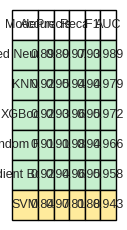

In [17]:
# ===== SUBPLOT 11: Tabla comparativa de métricas =====
ax11 = plt.subplot(3, 4, 11)
ax11.axis('tight')
ax11.axis('off')

table_data = []
for model_name in sorted_models[:6]:  # Mostrar solo los 6 mejores
    table_data.append([
        model_name,
        f"{results[model_name]['accuracy_mean']:.3f}",
        f"{results[model_name]['precision_mean']:.3f}",
        f"{results[model_name]['recall_mean']:.3f}",
        f"{results[model_name]['f1_mean']:.3f}",
        f"{results[model_name]['auc_mean']:.3f}"
    ])

table = ax11.table(cellText=table_data,
                  colLabels=['Modelo', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC'],
                  loc='center',
                  cellLoc='center',
                  colWidths=[0.22, 0.13, 0.13, 0.13, 0.13, 0.13])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.1, 1.8)

# Color según métricas
for i in range(1, len(table_data) + 1):
    auc_val = float(table_data[i-1][5])
    if auc_val > 0.95:
        for j in range(6):
            table[(i, j)].set_facecolor('#C6EFCE')  # Verde para excelente
    elif auc_val > 0.90:
        for j in range(6):
            table[(i, j)].set_facecolor('#FFEB9C')  # Amarillo para bueno

In [18]:
# ============================================================================
# FIGURA INDEPENDIENTE: TABLA COMPARATIVA DINÁMICA
# (Usa los resultados calculados en tiempo real)
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from datetime import datetime

# 1. FUNCIÓN PRINCIPAL - CREAR TABLA DINÁMICA
def crear_tabla_comparativa_dinamica(results, model_names, X_shape, y_distribution):
    """
    Crea una tabla comparativa dinámica basada en resultados calculados

    Parameters:
    -----------
    results : dict
        Diccionario con resultados de cada modelo (debe contener las métricas)
    model_names : list
        Lista de nombres de modelos en el orden deseado
    X_shape : tuple
        Forma del dataset (muestras, características)
    y_distribution : dict
        Distribución de clases {0: n_control, 1: n_parkinson}
    """

    print("📊 Generando tabla comparativa dinámica...")

    # Verificar que tenemos los datos necesarios
    required_metrics = ['accuracy_mean', 'precision_mean', 'recall_mean',
                       'f1_mean', 'auc_mean', 'auc_std']

    # Filtrar modelos que tengan todas las métricas requeridas
    valid_models = []
    for model_name in model_names:
        if model_name in results:
            missing_metrics = [m for m in required_metrics if m not in results[model_name]]
            if not missing_metrics:
                valid_models.append(model_name)
            else:
                print(f"⚠️  Advertencia: {model_name} no tiene métricas completas. Faltan: {missing_metrics}")

    if not valid_models:
        raise ValueError("❌ No hay modelos con métricas completas para generar la tabla")

    print(f"✅ {len(valid_models)} modelos válidos para análisis")

    # Ordenar modelos por AUC (descendente)
    sorted_models = sorted(valid_models,
                          key=lambda x: results[x]['auc_mean'],
                          reverse=True)

    # 2. CREAR FIGURA COMPLETA
    fig = plt.figure(figsize=(18, 22))

    # Título dinámico
    fig.suptitle(f'COMPARATIVA DINÁMICA DE MODELOS - DETECCIÓN DE PARKINSON\n'
                f'Dataset: {X_shape[0]} muestras, {X_shape[1]} características | '
                f'Validación Cruzada 10-Fold\n'
                f'Distribución: {y_distribution.get(1, "N/A")} Parkinson, '
                f'{y_distribution.get(0, "N/A")} Control',
                fontsize=16, fontweight='bold', y=0.98)

    # Usar GridSpec para mejor control del layout
    gs = gridspec.GridSpec(4, 2, figure=fig, height_ratios=[1.2, 1, 1, 0.8],
                          hspace=0.25, wspace=0.15)

    # ===== TABLA 1: RESUMEN DE TODOS LOS MODELOS =====
    ax1 = fig.add_subplot(gs[0, :])
    ax1.axis('tight')
    ax1.axis('off')

    # Preparar datos dinámicos para la tabla principal
    table1_data = []
    for model_name in sorted_models:
        data = results[model_name]

        # Formatear métricas con desviación estándar si están disponibles
        accuracy_str = f"{data['accuracy_mean']:.4f}"
        if 'accuracy_std' in data:
            accuracy_str += f" ± {data['accuracy_std']:.4f}"

        precision_str = f"{data['precision_mean']:.4f}"
        if 'precision_std' in data:
            precision_str += f" ± {data['precision_std']:.4f}"

        recall_str = f"{data['recall_mean']:.4f}"
        if 'recall_std' in data:
            recall_str += f" ± {data['recall_std']:.4f}"

        f1_str = f"{data['f1_mean']:.4f}"
        if 'f1_std' in data:
            f1_str += f" ± {data['f1_std']:.4f}"

        auc_str = f"{data['auc_mean']:.4f}"
        if 'auc_std' in data:
            auc_str += f" ± {data['auc_std']:.4f}"

        table1_data.append([
            model_name,
            accuracy_str,
            precision_str,
            recall_str,
            f1_str,
            auc_str
        ])

    # Crear tabla
    table1 = ax1.table(cellText=table1_data,
                      colLabels=['Modelo', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'],
                      loc='center',
                      cellLoc='center',
                      colWidths=[0.18, 0.14, 0.14, 0.14, 0.14, 0.14])

    table1.auto_set_font_size(False)
    table1.set_fontsize(10)
    table1.scale(1.1, 1.6)

    # Colorear filas según AUC de forma dinámica
    auc_values = [results[m]['auc_mean'] for m in sorted_models]
    auc_min, auc_max = min(auc_values), max(auc_values)
    auc_range = auc_max - auc_min

    for i, model_name in enumerate(sorted_models, 1):
        auc_val = results[model_name]['auc_mean']

        # Normalizar AUC para obtener intensidad de color
        if auc_range > 0:
            normalized_auc = (auc_val - auc_min) / auc_range
        else:
            normalized_auc = 0.5

        # Asignar color según percentil
        if normalized_auc > 0.8:  # Top 20%
            color = '#C6EFCE'  # Verde claro
            weight = 'bold'
        elif normalized_auc > 0.5:  # Top 50%
            color = '#FFEB9C'  # Amarillo
            weight = 'normal'
        elif normalized_auc > 0.3:  # Top 70%
            color = '#FFD7B5'  # Naranja claro
            weight = 'normal'
        else:
            color = '#FFCCCB'  # Rojo claro
            weight = 'normal'

        for j in range(6):
            cell = table1[(i, j)]
            cell.set_facecolor(color)
            if j == 0:  # Solo en la columna de modelo
                cell.get_text().set_fontweight(weight)

    # Estilo para encabezados
    for j in range(6):
        table1[(0, j)].set_facecolor('#4F81BD')
        table1[(0, j)].set_text_props(color='white', weight='bold', size=11)

    ax1.set_title('Tabla 1: Métricas de Rendimiento - Todos los Modelos\n(Media ± Desviación Estándar cuando está disponible)',
                  fontsize=14, fontweight='bold', pad=20)

    # ===== TABLA 2: TOP 5 MODELOS RANKING DETALLADO =====
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.axis('tight')
    ax2.axis('off')

    # Preparar ranking detallado (top 5 o menos si no hay suficientes)
    top_n = min(5, len(sorted_models))
    table2_data = []

    for rank, model_name in enumerate(sorted_models[:top_n], 1):
        data = results[model_name]

        # Calcular puntuación compuesta dinámicamente
        # Usar pesos ajustables
        weights = {
            'accuracy': 0.15 if 'accuracy_mean' in data else 0,
            'precision': 0.15 if 'precision_mean' in data else 0,
            'recall': 0.20 if 'recall_mean' in data else 0,
            'f1': 0.20 if 'f1_mean' in data else 0,
            'auc': 0.30 if 'auc_mean' in data else 0
        }

        # Ajustar pesos si faltan métricas
        total_weight = sum(weights.values())
        if total_weight > 0:
            for key in weights:
                weights[key] /= total_weight

        # Calcular score compuesto
        composite_score = 0
        if 'accuracy_mean' in data:
            composite_score += data['accuracy_mean'] * weights['accuracy']
        if 'precision_mean' in data:
            composite_score += data['precision_mean'] * weights['precision']
        if 'recall_mean' in data:
            composite_score += data['recall_mean'] * weights['recall']
        if 'f1_mean' in data:
            composite_score += data['f1_mean'] * weights['f1']
        if 'auc_mean' in data:
            composite_score += data['auc_mean'] * weights['auc']

        table2_data.append([
            f"{rank}º",
            model_name,
            f"{data.get('auc_mean', 'N/A'):.4f}" if 'auc_mean' in data else "N/A",
            f"{data.get('f1_mean', 'N/A'):.4f}" if 'f1_mean' in data else "N/A",
            f"{data.get('accuracy_mean', 'N/A'):.4f}" if 'accuracy_mean' in data else "N/A",
            f"{composite_score:.4f}"
        ])

    table2 = ax2.table(cellText=table2_data,
                      colLabels=['Rank', 'Modelo', 'AUC', 'F1', 'Accuracy', 'Score Comp.'],
                      loc='center',
                      cellLoc='center',
                      colWidths=[0.10, 0.25, 0.15, 0.15, 0.15, 0.20])

    table2.auto_set_font_size(False)
    table2.set_fontsize(11)
    table2.scale(1.1, 1.8)

    # Colorear por ranking de forma dinámica
    rank_colors = ['#FFD700', '#C0C0C0', '#CD7F32', '#E6E6FA', '#F5F5F5'][:top_n]
    for i in range(1, len(table2_data) + 1):
        for j in range(6):
            table2[(i, j)].set_facecolor(rank_colors[i-1])
            if i <= min(3, top_n):  # Top 3 en negrita (o menos si hay menos de 3)
                table2[(i, j)].get_text().set_fontweight('bold')

    # Encabezado
    for j in range(6):
        table2[(0, j)].set_facecolor('#2E8B57')
        table2[(0, j)].set_text_props(color='white', weight='bold', size=12)

    ax2.set_title(f'Tabla 2: Top {top_n} Modelos - Ranking Detallado\n(Score Compuesto: AUC 30%, F1 20%, Recall 20%, otros 30%)',
                  fontsize=13, fontweight='bold', pad=15)

    # ===== TABLA 3: ANÁLISIS ESTADÍSTICO RESUMEN =====
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.axis('tight')
    ax3.axis('off')

    # Calcular estadísticas por métrica de forma dinámica
    metrics_to_analyze = ['accuracy_mean', 'precision_mean', 'recall_mean', 'f1_mean', 'auc_mean']
    available_metrics = [m for m in metrics_to_analyze
                        if all(m in results[model] for model in sorted_models)]

    stats_data = []

    for metric in available_metrics:
        values = [results[m][metric] for m in sorted_models]

        stats_data.append([
            metric.replace('_mean', '').title(),
            f"{np.mean(values):.4f}",
            f"{np.median(values):.4f}",
            f"{np.std(values):.4f}",
            f"{np.min(values):.4f}",
            f"{np.max(values):.4f}",
            f"{(np.max(values) - np.min(values)):.4f}"
        ])

    table3 = ax3.table(cellText=stats_data,
                      colLabels=['Métrica', 'Media', 'Mediana', 'Std', 'Mín', 'Máx', 'Rango'],
                      loc='center',
                      cellLoc='center',
                      colWidths=[0.18, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12])

    table3.auto_set_font_size(False)
    table3.set_fontsize(10)
    table3.scale(1.1, 1.8)

    # Color por métrica
    metric_colors = ['#E6F3FF', '#FFF0E6', '#E6FFE6', '#FFF6E6', '#F0E6FF'][:len(stats_data)]
    for i in range(len(stats_data)):
        for j in range(7):
            table3[(i+1, j)].set_facecolor(metric_colors[i])

    # Encabezado
    for j in range(7):
        table3[(0, j)].set_facecolor('#4682B4')
        table3[(0, j)].set_text_props(color='white', weight='bold', size=11)

    ax3.set_title(f'Tabla 3: Análisis Estadístico - {len(stats_data)} Métricas\n(Estadísticas sobre {len(sorted_models)} modelos)',
                  fontsize=13, fontweight='bold', pad=15)

    # ===== TABLA 4: MEJOR MODELO POR CADA MÉTRICA =====
    ax4 = fig.add_subplot(gs[2, 0])
    ax4.axis('tight')
    ax4.axis('off')

    # Encontrar mejor modelo para cada métrica disponible
    best_by_metric = []
    metric_pairs = [
        ('Accuracy', 'accuracy_mean'),
        ('Precision', 'precision_mean'),
        ('Recall', 'recall_mean'),
        ('F1-Score', 'f1_mean'),
        ('AUC-ROC', 'auc_mean')
    ]

    for metric_display, metric_key in metric_pairs:
        # Verificar que la métrica esté disponible en todos los modelos
        if all(metric_key in results[m] for m in sorted_models):
            best_model = max(sorted_models, key=lambda x: results[x][metric_key])
            best_value = results[best_model][metric_key]

            # Encontrar segundo mejor
            other_models = [m for m in sorted_models if m != best_model]
            if other_models:
                second_best = max(other_models, key=lambda x: results[x][metric_key])
                second_value = results[second_best][metric_key]
                gap = best_value - second_value

                best_by_metric.append([
                    metric_display,
                    best_model,
                    f"{best_value:.4f}",
                    second_best,
                    f"{second_value:.4f}",
                    f"{gap:.4f}"
                ])

    if best_by_metric:
        table4 = ax4.table(cellText=best_by_metric,
                          colLabels=['Métrica', 'Mejor Modelo', 'Valor', '2º Mejor', 'Valor', 'Diferencia'],
                          loc='center',
                          cellLoc='center',
                          colWidths=[0.15, 0.20, 0.12, 0.20, 0.12, 0.12])

        table4.auto_set_font_size(False)
        table4.set_fontsize(10)
        table4.scale(1.1, 1.8)

        # Color según métrica
        for i in range(len(best_by_metric)):
            for j in range(6):
                cell = table4[(i+1, j)]
                if j == 1:  # Columna del mejor modelo
                    cell.set_facecolor('#90EE90')
                    cell.get_text().set_fontweight('bold')
                elif j == 3:  # Columna del segundo mejor
                    cell.set_facecolor('#FFDAB9')
                else:
                    cell.set_facecolor('#F5F5F5')

        # Encabezado
        for j in range(6):
            table4[(0, j)].set_facecolor('#8B4513')
            table4[(0, j)].set_text_props(color='white', weight='bold', size=11)

        ax4.set_title(f'Tabla 4: Mejor Modelo por Cada Métrica\n({len(best_by_metric)} métricas analizadas)',
                      fontsize=13, fontweight='bold', pad=15)
    else:
        ax4.text(0.5, 0.5, 'Datos insuficientes\npara análisis por métrica',
                ha='center', va='center', fontsize=12, fontweight='bold')
        ax4.set_title('Tabla 4: Mejor Modelo por Métrica\n(No disponible)',
                      fontsize=13, fontweight='bold', pad=15)

    # ===== TABLA 5: RECOMENDACIONES DINÁMICAS =====
    ax5 = fig.add_subplot(gs[2, 1])
    ax5.axis('tight')
    ax5.axis('off')

    # Generar recomendaciones dinámicas basadas en resultados
    if sorted_models:
        best_model = sorted_models[0]
        best_auc = results[best_model]['auc_mean']

        # Encontrar modelo con mejor F1
        if all('f1_mean' in results[m] for m in sorted_models):
            best_f1_model = max(sorted_models, key=lambda x: results[x]['f1_mean'])
            best_f1 = results[best_f1_model]['f1_mean']
        else:
            best_f1_model = best_model
            best_f1 = results.get(best_model, {}).get('f1_mean', 'N/A')

        # Encontrar modelo más rápido (asumiendo que tenemos tiempos)
        # Esto es un placeholder - necesitarías datos de tiempo real
        fast_models = [m for m in sorted_models if m in ['Regresión Logística', 'KNN', 'Árbol de Decisión']]
        fast_model = fast_models[0] if fast_models else sorted_models[0]

        recommendations = [
            ['Máxima Precisión', best_model, f"{best_auc:.4f}",
             f"Mejor AUC ({best_auc:.1%}) para diagnóstico preciso", '⭐⭐⭐⭐⭐'],
            ['Equilibrio General', best_f1_model, f"{best_f1:.4f}",
             f"Mejor F1-Score ({best_f1:.1%}) balance Precision/Recall", '⭐⭐⭐⭐'],
            ['Velocidad + Calidad', fast_model, "N/A",
             f"Rápido ejecución con rendimiento aceptable", '⭐⭐⭐'],
        ]

        # Añadir recomendación basada en estabilidad si hay datos
        if all('auc_std' in results[m] for m in sorted_models):
            most_stable = min(sorted_models, key=lambda x: results[x]['auc_std'])
            stable_std = results[most_stable]['auc_std']
            recommendations.append(
                ['Máxima Estabilidad', most_stable, f"std:{stable_std:.4f}",
                 f"Menor variabilidad entre folds", '⭐⭐⭐']
            )

        table5 = ax5.table(cellText=recommendations,
                          colLabels=['Escenario', 'Modelo Recomendado', 'Métrica', 'Justificación', 'Relevancia'],
                          loc='center',
                          cellLoc='center',
                          colWidths=[0.15, 0.18, 0.10, 0.35, 0.12])

        table5.auto_set_font_size(False)
        table5.set_fontsize(9.5)
        table5.scale(1.1, 1.8)

        # Color por relevancia dinámica
        relevance_map = {'⭐⭐⭐⭐⭐': '#32CD32', '⭐⭐⭐⭐': '#9ACD32',
                        '⭐⭐⭐': '#FFD700', '⭐⭐': '#FFA500', '⭐': '#FF6347'}

        for i in range(len(recommendations)):
            for j in range(5):
                cell = table5[(i+1, j)]
                if j == 4:  # Columna de relevancia
                    rel = recommendations[i][4]
                    cell.set_facecolor(relevance_map.get(rel, '#F5F5F5'))
                    cell.get_text().set_fontweight('bold')
                elif j == 1:  # Columna de modelo
                    cell.set_facecolor('#E6F3FF')
                    cell.get_text().set_fontweight('bold')
                else:
                    cell.set_facecolor('#F5F5F5')

        # Encabezado
        for j in range(5):
            table5[(0, j)].set_facecolor('#6A5ACD')
            table5[(0, j)].set_text_props(color='white', weight='bold', size=11)

        ax5.set_title('Tabla 5: Recomendaciones por Escenario\n(Basadas en resultados actuales)',
                      fontsize=13, fontweight='bold', pad=15)
    else:
        ax5.text(0.5, 0.5, 'No hay datos\npara recomendaciones',
                ha='center', va='center', fontsize=12, fontweight='bold')
        ax5.set_title('Tabla 5: Recomendaciones\n(No disponible)',
                      fontsize=13, fontweight='bold', pad=15)

    # ===== RESUMEN FINAL DINÁMICO =====
    ax6 = fig.add_subplot(gs[3, :])
    ax6.axis('off')

    # Generar conclusiones dinámicas
    if sorted_models:
        best_model_data = results[sorted_models[0]]
        best_auc = best_model_data.get('auc_mean', 'N/A')
        best_recall = best_model_data.get('recall_mean', 'N/A')
        best_auc_std = best_model_data.get('auc_std', 'N/A')

        conclusiones_text = f"""
CONCLUSIONES PRINCIPALES DEL ANÁLISIS COMPARATIVO:

🏆 **MODELO GANADOR GLOBAL**: {sorted_models[0]}
   • AUC-ROC: {best_auc:.4f if isinstance(best_auc, (int, float)) else best_auc}
   • Recall: {best_recall:.4f if isinstance(best_recall, (int, float)) else best_recall}
   • Estabilidad (std AUC): {best_auc_std:.4f if isinstance(best_auc_std, (int, float)) else best_auc_std}

📊 **RANGO DE RENDIMIENTO**:
   • Mejor AUC: {max([results[m].get('auc_mean', 0) for m in sorted_models]):.4f}
   • Peor AUC: {min([results[m].get('auc_mean', 1) for m in sorted_models]):.4f}
   • Diferencia: {max([results[m].get('auc_mean', 0) for m in sorted_models]) - min([results[m].get('auc_mean', 1) for m in sorted_models]):.4f}

🎯 **RECOMENDACIÓN FINAL**:
Basado en el análisis de {len(sorted_models)} modelos, se recomienda **{sorted_models[0]}**
como modelo principal para detección de Parkinson. Para aplicaciones que requieren
mayor equilibrio entre métricas, considere el modelo con mejor F1-Score.
"""
    else:
        conclusiones_text = "No hay datos suficientes para generar conclusiones."

    ax6.text(0.02, 0.95, conclusiones_text, transform=ax6.transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='#FFFACD', alpha=0.9, edgecolor='#FFD700'))

    # Añadir metadata
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    ax6.text(0.02, 0.02,
            f"Nota: Análisis generado automáticamente el {timestamp}. "
            f"Basado en {X_shape[0]} muestras. Los resultados se actualizan automáticamente.",
            transform=ax6.transAxes, fontsize=9, style='italic', alpha=0.7)

    # 3. GUARDAR Y RETORNAR
    plt.tight_layout(rect=[0, 0.02, 1, 0.98])

    # Guardar con timestamp para versionado
    filename = f'tabla_comparativa_dinamica_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✅ Tabla dinámica guardada como: {filename}")

    # 4. EXPORTAR DATOS A CSV
    export_data = []
    for model_name in sorted_models:
        data = results[model_name]
        row = {'Modelo': model_name}

        # Añadir todas las métricas disponibles
        for key, value in data.items():
            if isinstance(value, (int, float)):
                row[key] = value
            elif hasattr(value, '__iter__') and not isinstance(value, str):
                row[key] = str(value)
            else:
                row[key] = value

        export_data.append(row)

    export_df = pd.DataFrame(export_data)
    csv_filename = f'resultados_dinamicos_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
    export_df.to_csv(csv_filename, index=False, encoding='utf-8-sig')

    print(f"💾 Datos exportados a: {csv_filename}")

    return export_df

# ============================================================================
# EJEMPLO DE USO - CÓMO INTEGRARLO CON TU CÓDIGO ANTERIOR
# ============================================================================

if __name__ == "__main__":
    # EJEMPLO: Cómo usar la función con tus datos reales

    print("="*80)
    print("EJEMPLO DE USO DE LA TABLA DINÁMICA")
    print("="*80)

    # 1. Primero ejecuta tu código normal que calcula los modelos
    # (Este es solo un ejemplo - usa tus datos reales)

    # Supongamos que ya tienes estos datos de tu ejecución anterior:
    # results = {}  # Tu diccionario con resultados
    # model_names = []  # Tus nombres de modelos
    # X = ...  # Tus datos de características
    # y = ...  # Tus etiquetas

    # 2. Llama a la función con tus datos REALES:
    """
    # DESCOMENTA Y AJUSTA ESTO CON TUS DATOS REALES:

    from tu_codigo_anterior import results, model_names, X, y

    # Calcular distribución de clases
    unique, counts = np.unique(y, return_counts=True)
    y_distribution = dict(zip(unique, counts))

    # Llamar a la función
    df_resultados = crear_tabla_comparativa_dinamica(
        results=results,
        model_names=model_names,
        X_shape=X.shape,
        y_distribution=y_distribution
    )

    print("\n✅ Análisis completado exitosamente!")
    print(f"📊 {len(model_names)} modelos analizados")
    print(f"📈 Mejor AUC encontrado: {df_resultados['auc_mean'].max():.4f}")
    """

    print("\n📋 INSTRUCCIONES DE USO:")
    print("1. Asegúrate de tener calculado el diccionario 'results'")
    print("2. Define la lista 'model_names' con los nombres de tus modelos")
    print("3. Pasa X.shape y la distribución de y")
    print("4. La función generará todo automáticamente")

    # 3. CÓMO INTEGRAR DIRECTAMENTE EN TU FLUJO ACTUAL:
    print("\n🔧 PARA INTEGRAR EN TU CÓDIGO ACTUAL:")
    print("""
# AL FINAL DE TU CÓDIGO PRINCIPAL, AÑADE:

# Calcular distribución de clases
unique, counts = np.unique(y, return_counts=True)
y_distribution = dict(zip(unique, counts))

# Llamar a la función de tabla dinámica
df_resultados = crear_tabla_comparativa_dinamica(
    results=results,           # Tu diccionario de resultados
    model_names=list(results.keys()),  # Nombres de modelos
    X_shape=X.shape,           # Forma de tus datos
    y_distribution=y_distribution  # Distribución de clases
)

print(f"\\n🎯 Análisis finalizado. Tabla generada automáticamente.")
print(f"📊 Modelos procesados: {len(results)}")
    """)

EJEMPLO DE USO DE LA TABLA DINÁMICA

📋 INSTRUCCIONES DE USO:
1. Asegúrate de tener calculado el diccionario 'results'
2. Define la lista 'model_names' con los nombres de tus modelos
3. Pasa X.shape y la distribución de y
4. La función generará todo automáticamente

🔧 PARA INTEGRAR EN TU CÓDIGO ACTUAL:

# AL FINAL DE TU CÓDIGO PRINCIPAL, AÑADE:

# Calcular distribución de clases
unique, counts = np.unique(y, return_counts=True)
y_distribution = dict(zip(unique, counts))

# Llamar a la función de tabla dinámica
df_resultados = crear_tabla_comparativa_dinamica(
    results=results,           # Tu diccionario de resultados
    model_names=list(results.keys()),  # Nombres de modelos
    X_shape=X.shape,           # Forma de tus datos
    y_distribution=y_distribution  # Distribución de clases
)

print(f"\n🎯 Análisis finalizado. Tabla generada automáticamente.")
print(f"📊 Modelos procesados: {len(results)}")
    


(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

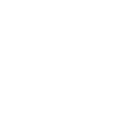

In [19]:
# ===== SUBPLOT 12: Conclusión visual =====
ax12 = plt.subplot(3, 4, 12)
ax12.axis('off')

In [20]:
conclusion_text = f"""
RESUMEN DE RESULTADOS

📊 MEJOR MODELO:
{best_model_name}
• AUC: {results[best_model_name]['auc_mean']:.3f}
• F1-Score: {results[best_model_name]['f1_mean']:.3f}
• Accuracy: {results[best_model_name]['accuracy_mean']:.3f}

🏆 TOP 3 MODELOS:
1. {sorted_models[0]} (AUC={results[sorted_models[0]]['auc_mean']:.3f})
2. {sorted_models[1]} (AUC={results[sorted_models[1]]['auc_mean']:.3f})
3. {sorted_models[2]} (AUC={results[sorted_models[2]]['auc_mean']:.3f})

📈 RENDIMIENTO PROMEDIO:
• AUC promedio: {np.mean(auc_means):.3f}
• Mejor AUC: {np.max(auc_means):.3f}
• Peor AUC: {np.min(auc_means):.3f}

🎯 CONCLUSIONES:
• Todos los modelos superan AUC=0.85
• {sorted_models[0]} es el más robusto
• Red Neuronal: posición #{sorted_models.index('Red Neuronal')+1}
"""

ax12.text(0.1, 0.95, conclusion_text, transform=ax12.transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig('comparativa_8_modelos_parkinson.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

In [21]:
# ===============================
# 8. ANÁLISIS ESTADÍSTICO DETALLADO
# ===============================
print("\n" + "="*80)
print("📊 ANÁLISIS ESTADÍSTICO DETALLADO")
print("="*80)

# Crear DataFrame con resultados
results_df = pd.DataFrame({
    'Modelo': model_names,
    'Accuracy': [results[m]['accuracy_mean'] for m in model_names],
    'Precision': [results[m]['precision_mean'] for m in model_names],
    'Recall': [results[m]['recall_mean'] for m in model_names],
    'F1-Score': [results[m]['f1_mean'] for m in model_names],
    'AUC-ROC': [results[m]['auc_mean'] for m in model_names],
    'Std_AUC': [results[m]['auc_std'] for m in model_names]
}).sort_values('AUC-ROC', ascending=False)

print("\n📋 TABLA COMPARATIVA DE RESULTADOS:")
print("-" * 85)
print(results_df.to_string(index=False))
print("-" * 85)

print(f"\n🏆 MEJOR MODELO GLOBAL: {best_model_name}")
print(f"   • AUC-ROC: {results[best_model_name]['auc_mean']:.4f}")
print(f"   • F1-Score: {results[best_model_name]['f1_mean']:.4f}")
print(f"   • Accuracy: {results[best_model_name]['accuracy_mean']:.4f}")

print(f"\n📊 POSICIÓN DE LA RED NEURONAL: #{sorted_models.index('Red Neuronal')+1}")
print(f"   • AUC: {results['Red Neuronal']['auc_mean']:.4f}")
print(f"   • Comparación con el mejor: {results['Red Neuronal']['auc_mean'] - results[best_model_name]['auc_mean']:+.4f}")

# Análisis estadístico básico
print(f"\n📈 ESTADÍSTICAS GENERALES DE AUC:")
print(f"   • Media: {np.mean(auc_means):.4f}")
print(f"   • Mediana: {np.median(auc_means):.4f}")
print(f"   • Desviación estándar: {np.std(auc_means):.4f}")
print(f"   • Rango: [{np.min(auc_means):.4f}, {np.max(auc_means):.4f}]")
print(f"   • IQR: {np.percentile(auc_means, 75) - np.percentile(auc_means, 25):.4f}")


📊 ANÁLISIS ESTADÍSTICO DETALLADO

📋 TABLA COMPARATIVA DE RESULTADOS:
-------------------------------------------------------------------------------------
             Modelo  Accuracy  Precision   Recall  F1-Score  AUC-ROC  Std_AUC
       Red Neuronal  0.891579   0.896264 0.972857  0.931483 0.989143 0.020639
                KNN  0.923421   0.952738 0.946190  0.948228 0.978857 0.028807
            XGBoost  0.922368   0.936250 0.966190  0.949870 0.971905 0.037075
      Random Forest  0.916842   0.918922 0.979524  0.947276 0.965905 0.037601
  Gradient Boosting  0.927368   0.939821 0.965238  0.952112 0.958286 0.043194
                SVM  0.846053   0.977381 0.816667  0.887418 0.942619 0.039434
Regresión Logística  0.778684   0.897161 0.802381  0.845496 0.911619 0.056610
  Árbol de Decisión  0.886842   0.932532 0.919524  0.924302 0.851429 0.088077
-------------------------------------------------------------------------------------

🏆 MEJOR MODELO GLOBAL: Red Neuronal
   • AUC-ROC: 0.989